In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable

# Define Data paths and Preprocessing

In [30]:
data_name = 'papyrus'
activity_type = 'xc50'
# activity_type = 'kx'
type_n_targets = 'all'
project_name = '2024-06-25-all-models-100'
# project_name = '2024-07-22-all-models-100-kx'
project_out_name = f'reassess-{project_name}'
data_specific_path = f'{data_name}/{activity_type}/{type_n_targets}'
# DESCRIPTORS
descriptor_protein='ankh-large'
descriptor_chemical='ecfp2048'
prot_input_dim=1536
chem_input_dim=2048

# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/metrics|_.csv'
# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/metrics_manual.csv'
file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/metrics.csv'
save_dir = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/'

In [31]:
df_main = pd.read_csv(file_path, header=0)
df_main.columns = df_main.columns.str.strip() 
# print(df_main.shape)
df_main.head(10)

,Model type,Task,Activity,Split,desc_prot,desc_chem,dropout,R2,RMSE,MAE,...,Z_mean_CI_high,rmv_rmse_slope,rmv_rmse_r_sq,rmv_rmse_intercept,aleatoric_uct_mean,epistemic_uct_mean,total_uct_mean,wandb project,wandb run,model name
0,ensemble,PCM,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.074273,1.038226,0.866887,0.253268,0.437120,0.087706,0.524826,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
1,ensemble,PCM_subset_100,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.073938,1.038226,0.866887,0.253268,0.437120,0.087706,0.524826,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
2,ensemble,PCM_before_calibration,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.072987,1.038226,0.866887,0.253268,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
3,ensemble,PCM_before_calibration_subset_100,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.073483,1.038226,0.866887,0.253268,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
4,ensemble,PCM_after_calibration_with_isotonic_regression,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.073807,1.038226,0.866887,0.253268,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
5,ensemble,PCM_after_calibration_with_isotonic_regression...,xc50,random,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,-0.073909,1.038226,0.866887,0.253268,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...
6,ensemble,PCM,xc50,random,ankh-large,ecfp2048,0.1,0.636459,0.727458,0.547726,...,-0.076006,1.033294,0.886369,0.258091,0.435544,0.088321,0.523865,reassess-2024-06-25-all-models-100_for_metrics,exalted-gorge-1,20240625-papyrus_xc50_ensemble_random_ankh-lar...
7,ensemble,PCM_subset_100,xc50,random,ankh-large,ecfp2048,0.1,0.636459,0.727458,0.547726,...,-0.075743,1.033294,0.886369,0.258091,0.435544,0.088321,0.523865,reassess-2024-06-25-all-models-100_for_metrics,exalted-gorge-1,20240625-papyrus_xc50_ensemble_random_ankh-lar...
8,ensemble,PCM_before_calibration,xc50,random,ankh-large,ecfp2048,0.1,0.636459,0.727458,0.547726,...,-0.074839,1.033294,0.886369,0.258091,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,exalted-gorge-1,20240625-papyrus_xc50_ensemble_random_ankh-lar...
9,ensemble,PCM_before_calibration_subset_100,xc50,random,ankh-large,ecfp2048,0.1,0.636459,0.727458,0.547726,...,-0.075242,1.033294,0.886369,0.258091,NaN,NaN,NaN,reassess-2024-06-25-all-models-100_for_metrics,exalted-gorge-1,20240625-papyrus_xc50_ensemble_random_ankh-lar...


In [32]:
# Extract the run name from 'model name' in the main data
# df_main['RunName'] = df_main['model name'].apply(lambda x: x.split('_')[-1])

df_main.shape

(1080, 43)

In [33]:
1080/6

180.0

In [35]:
# # replace random with stratified for the random split
df_main['Split'] = df_main['Split'].apply(lambda x: 'stratified' if x == 'random' else x)

df_merged = df_main.copy()

# Remove some rows where MCDP experiment was run 
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'scaffold_cluster') & (df_merged['dropout'] == 0.1))]
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'stratified') & (df_merged['dropout'] == 0.2))]
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'time') & (df_merged['dropout'] == 0.1))]

df_merged['Group'] = df_merged.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)

# Extracting the necessary parts for plotting and make copies to avoid SettingWithCopyWarning
# df_pcm with exact match of task pcm
df_pcm = df_merged[df_merged['Task'] == 'PCM'].copy()
df_before_calib = df_merged[df_merged['Task'] == 'PCM_before_calibration'].copy()
df_before_calib['Calibration'] = 'Before Calibration'

df_after_calib = df_merged[df_merged['Task'] == 'PCM_after_calibration_with_isotonic_regression'].copy()
df_after_calib['Calibration'] = 'After Calibration'

df_calib = pd.concat([df_before_calib, df_after_calib])

# SUBSET 100
subdf_pcm = df_merged[df_merged['Task'] == 'PCM_subset100'].copy()
subdf_before_calib = df_merged[df_merged['Task'] == 'PCM_before_calibration_subset100'].copy()
subdf_before_calib['Calibration'] = 'Before Calibration'

subdf_after_calib = df_merged[df_merged['Task'] == 'PCM_after_calibration_with_isotonic_regression_subset100'].copy()
subdf_after_calib['Calibration'] = 'After Calibration'

subdf_calib = pd.concat([subdf_before_calib, subdf_after_calib])

# group_order = [
#     "stratified_ensemble",
#     "stratified_evidential",
#     "stratified_mcdropout",
#     "scaffold_cluster_ensemble",
#     "scaffold_cluster_evidential",
#     "scaffold_cluster_mcdropout"
# ]
group_order = [
    "stratified_ensemble",
    "stratified_evidential",
    "stratified_eoe",
    "stratified_emc",
    "stratified_mcdropout",
    "scaffold_cluster_ensemble",
    "scaffold_cluster_evidential",
    "scaffold_cluster_eoe",
    "scaffold_cluster_emc",
    "scaffold_cluster_mcdropout",
    "time_ensemble",
    "time_evidential",
    "time_eoe",
    "time_emc",
    "time_mcdropout",
]

In [6]:
# df_after_calib.head()

In [18]:
df_pcm.head()

,Model type,Task,Activity,Split,desc_prot,desc_chem,dropout,R2,RMSE,MAE,...,rmv_rmse_slope,rmv_rmse_r_sq,rmv_rmse_intercept,aleatoric_uct_mean,epistemic_uct_mean,total_uct_mean,wandb project,wandb run,model name,Group
0,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.637286,0.726630,0.547146,...,1.038226,0.866887,0.253268,0.437120,0.087706,0.524826,reassess-2024-06-25-all-models-100_for_metrics,peach-wave-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...,stratified_ensemble
6,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.636459,0.727458,0.547726,...,1.033294,0.886369,0.258091,0.435544,0.088321,0.523865,reassess-2024-06-25-all-models-100_for_metrics,exalted-gorge-1,20240625-papyrus_xc50_ensemble_random_ankh-lar...,stratified_ensemble
12,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.626951,0.736910,0.558098,...,0.998964,0.879338,0.213471,0.503729,0.140191,0.643921,reassess-2024-06-25-all-models-100_for_metrics,clear-wood-4,20240625-papyrus_xc50_ensemble_random_ankh-lar...,stratified_ensemble
18,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.637408,0.726508,0.547002,...,1.036738,0.872798,0.256100,0.435141,0.088157,0.523297,reassess-2024-06-25-all-models-100_for_metrics,avid-energy-14,20240625-papyrus_xc50_ensemble_random_ankh-lar...,stratified_ensemble
24,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.636473,0.727444,0.547727,...,1.037042,0.872239,0.254822,0.437000,0.088189,0.525189,reassess-2024-06-25-all-models-100_for_metrics,colorful-darkness-9,20240625-papyrus_xc50_ensemble_random_ankh-lar...,stratified_ensemble


In [19]:
df_pcm.shape

(150, 44)

In [36]:
# RESULTS AGGREGATION TO CREATE THE FINAL RESULTS TABLE
df = df_pcm.copy()
def aggregate_results_csv(df, group_cols, numeric_cols, string_cols, order_by=None, output_file_path=None):
    # Group the DataFrame by the specified columns
    grouped = df.groupby(group_cols)
    # Aggregate the numeric columns
    aggregated = grouped[numeric_cols].agg(['mean', 'std'])
    # Combine mean and std into the required format
    for col in numeric_cols:
        aggregated[(col, 'combined')] = aggregated[(col, 'mean')].round(3).astype(str) + '(' + aggregated[(col, 'std')].round(3).astype(str) + ')'
    # Drop the separate mean and std columns, keeping only the combined column
    aggregated = aggregated[[col for col in aggregated.columns if col[1] == 'combined']]

    # Rename the columns to a simpler format
    aggregated.columns = [col[0] for col in aggregated.columns]

    # Step 6: Aggregate the string columns into lists
    string_aggregated = grouped[string_cols].agg(lambda x: list(x))

    # Combine the numeric and string aggregations
    final_aggregated = pd.concat([aggregated, string_aggregated], axis=1).reset_index()
    if order_by:
        final_aggregated = final_aggregated.sort_values(by=order_by)
        
    if output_file_path:
        final_aggregated.to_csv(output_file_path, index=False)
    return final_aggregated

# # Group the DataFrame by the specified columns
# grouped = df.groupby(group_cols)
# # Aggregate the numeric columns
# aggregated = grouped[numeric_cols].agg(['mean', 'std'])
# # Combine mean and std into the required format
# for col in numeric_cols:
#     aggregated[(col, 'combined')] = aggregated[(col, 'mean')].round(3).astype(str) + ' (' + aggregated[(col, 'std')].round(3).astype(str) + ')'
# # Drop the separate mean and std columns, keeping only the combined column
# aggregated = aggregated[[col for col in aggregated.columns if col[1] == 'combined']]
# 
# # Rename the columns to a simpler format
# aggregated.columns = [col[0] for col in aggregated.columns]
# 
# # Step 6: Aggregate the string columns into lists
# string_aggregated = grouped[string_cols].agg(lambda x: list(x))
# 
# # Combine the numeric and string aggregations
# final_aggregated = pd.concat([aggregated, string_aggregated], axis=1).reset_index()

In [37]:
group_cols = ['Model type', 'Task', 'Activity', 'Split', 'desc_prot', 'desc_chem', 'dropout']
numeric_cols = ['RMSE', 'R2', 'MAE', 'MDAE', 'MARPD', 'PCC', 'RMS Calibration', 'MA Calibration',
                    'Miscalibration Area', 'Sharpness', 'NLL', 'CRPS', 'Check', 'Interval', 'rho_rank',
                    'rho_rank_sim', 'rho_rank_sim_std', 'uq_mis_cal', 'uq_NLL', 'uq_NLL_sim', 
                    'uq_NLL_sim_std', 'Z_var', 'Z_var_CI_low', 'Z_var_CI_high', 'Z_mean', 
                    'Z_mean_CI_low', 'Z_mean_CI_high', 'rmv_rmse_slope', 'rmv_rmse_r_sq','rmv_rmse_intercept', 'aleatoric_uct_mean', 'epistemic_uct_mean', 
                    'total_uct_mean']
string_cols = ['wandb project', 'wandb run', 'model name']
order_by = ['Split', 'Model type']
# TODO 
# output_file_path = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100_for_metrics/final_aggregated_2.csv'
output_file_path = os.path.join(save_dir, 'final_aggregated.csv')
final_aggregated = aggregate_results_csv(df, group_cols, numeric_cols, string_cols, order_by, output_file_path)

In [38]:
final_aggregated.head(10)

,Model type,Task,Activity,Split,desc_prot,desc_chem,dropout,RMSE,R2,MAE,...,Z_mean_CI_high,rmv_rmse_slope,rmv_rmse_r_sq,rmv_rmse_intercept,aleatoric_uct_mean,epistemic_uct_mean,total_uct_mean,wandb project,wandb run,model name
0,emc,PCM,xc50,scaffold_cluster,ankh-large,ecfp2048,0.2,0.92(0.004),0.382(0.005),0.716(0.002),...,-0.043(0.007),-0.033(0.091),0.024(0.022),0.953(0.095),1.051(0.033),2.513(0.041),3.564(0.063),"[2024-06-25-all-models-100, 2024-06-25-all-mod...","[cool-dragon-171, major-firebrand-169, fast-pl...",[20240902-papyrus_xc50_emc_scaffold_cluster_an...
3,ensemble,PCM,xc50,scaffold_cluster,ankh-large,ecfp2048,0.2,0.878(0.001),0.437(0.001),0.685(0.001),...,-0.109(0.008),0.425(0.016),0.583(0.028),0.542(0.022),0.776(0.023),0.23(0.01),1.006(0.033),[reassess-2024-06-25-all-models-100_for_metric...,"[cosmic-field-83, copper-oath-17, cerulean-res...",[20240626-papyrus_xc50_ensemble_scaffold_clust...
6,eoe,PCM,xc50,scaffold_cluster,ankh-large,ecfp2048,0.2,0.871(0.002),0.447(0.002),0.675(0.002),...,-0.052(0.003),-2.166(0.967),0.137(0.074),3.061(0.964),1.015(0.008),2.535(0.013),3.55(0.018),"[2024-06-25-all-models-100, 2024-06-25-all-mod...","[logical-feather-165, glad-universe-167, happy...",[20240820-papyrus_xc50_eoe_scaffold_cluster_an...
9,evidential,PCM,xc50,scaffold_cluster,ankh-large,ecfp2048,0.2,0.9(0.004),0.408(0.006),0.698(0.003),...,-0.051(0.006),-1.129(0.62),0.079(0.065),2.044(0.629),1.012(0.012),2.512(0.04),3.524(0.044),[reassess-2024-06-25-all-models-100_for_metric...,"[polished-durian-32, pretty-pyramid-72, youthf...",[20240625-papyrus_xc50_evidential_scaffold_clu...
12,mcdropout,PCM,xc50,scaffold_cluster,ankh-large,ecfp2048,0.2,0.91(0.006),0.395(0.008),0.711(0.005),...,-0.11(0.012),0.346(0.046),0.514(0.093),0.634(0.036),0.787(0.023),0.654(0.029),1.44(0.047),"[reassess-2024-06-25-all-models-100, reassess-...","[legendary-dust-51, vibrant-sun-64, prime-sky-...",[20240625-papyrus_xc50_mcdropout_scaffold_clus...
1,emc,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.729(0.004),0.635(0.004),0.541(0.004),...,0.003(0.006),0.185(0.2),0.067(0.117),0.576(0.163),0.805(0.032),2.005(0.05),2.81(0.08),"[2024-06-25-all-models-100, 2024-06-25-all-mod...","[sparkling-breeze-172, comic-sound-170, silver...",[20240902-papyrus_xc50_emc_random_ankh-large_e...
4,ensemble,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.728(0.003),0.636(0.003),0.549(0.003),...,-0.076(0.007),1.031(0.012),0.872(0.008),0.251(0.014),0.444(0.021),0.093(0.017),0.537(0.038),[reassess-2024-06-25-all-models-100_for_metric...,"[peach-wave-9, exalted-gorge-1, clear-wood-4, ...",[20240625-papyrus_xc50_ensemble_random_ankh-la...
7,eoe,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.709(0.001),0.654(0.001),0.522(0.001),...,-0.021(0.002),0.115(0.045),0.016(0.01),0.614(0.036),0.801(0.009),1.989(0.013),2.79(0.022),"[2024-06-25-all-models-100, 2024-06-25-all-mod...","[misunderstood-pond-138, desert-terrain-141, b...",[20240820-papyrus_xc50_eoe_random_ankh-large_e...
10,evidential,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.717(0.005),0.647(0.005),0.529(0.004),...,-0.023(0.008),0.154(0.189),0.047(0.071),0.589(0.154),0.804(0.032),1.99(0.046),2.794(0.076),[reassess-2024-06-25-all-models-100_for_metric...,"[astral-field-70, apricot-music-36, rare-water...",[20240625-papyrus_xc50_evidential_random_ankh-...
13,mcdropout,PCM,xc50,stratified,ankh-large,ecfp2048,0.1,0.732(0.006),0.632(0.006),0.552(0.005),...,-0.03(0.009),1.038(0.064),0.86(0.016),0.252(0.029),0.445(0.016),0.421(0.015),0.867(0.025),"[reassess-2024-06-25-all-models-100, reassess-...","[rural-water-68, cool-planet-69, rose-leaf-58,...",[20240625-papyrus_xc50_mcdropout_random_ankh-l...


In [11]:
# output_file_path2 = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/final_aggregated_2.tex'
# final_aggregated.to_csv(output_file_path2, index=False, sep="&", lineterminator=" \\\\\n" )

In [39]:
# SEPARATE SPECIAL MC EXPERIMENT
mcdp_df = df_main[df_main['Model type'] == 'mcdropout'].copy()

mcdp_df['Group'] = mcdp_df.apply(lambda row: f"{row['Split']}_dropout{row['dropout']}", axis=1)

mcdp_df_pcm = mcdp_df[mcdp_df['Task'] == 'PCM'].copy()
mcdp_before_calib = mcdp_df[mcdp_df['Task'] == 'PCM_before_calibration'].copy()
mcdp_before_calib['Calibration'] = 'Before Calibration'

mcdp_after_calib_iso = mcdp_df[mcdp_df['Task'] == 'PCM_after_calibration_with_isotonic_regression'].copy()
mcdp_after_calib_iso['Calibration'] = 'After Calibration'
mcdp_calib = pd.concat([mcdp_before_calib, mcdp_after_calib_iso])

submcdp_df_pcm = mcdp_df[mcdp_df['Task'] == 'PCM_subset100'].copy()
submcdp_before_calib = mcdp_df[mcdp_df['Task'] == 'PCM_before_calibration_subset100'].copy()
submcdp_before_calib['Calibration'] = 'Before Calibration'

submcdp_after_calib_iso = mcdp_df[mcdp_df['Task'] == 'PCM_after_calibration_with_isotonic_regression_subset100'].copy()
submcdp_after_calib_iso['Calibration'] = 'After Calibration'

submcdp_calib = pd.concat([submcdp_before_calib, submcdp_after_calib_iso])

mc_group_order = [
    "stratified_dropout0.1",
    "stratified_dropout0.2",
    "scaffold_cluster_dropout0.1",
    "scaffold_cluster_dropout0.2",
    "time_dropout0.1",
    "time_dropout0.2"
]

## Helper plotting functions

In [47]:
# HELPER FUNCTIONS FOR PLOTTING #
def save_plot(fig, save_dir, plot_name, tighten=True):
    if tighten:
        plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{plot_name}.png"), dpi=1200)
        fig.savefig(os.path.join(save_dir, f"{plot_name}.svg"))
        fig.savefig(os.path.join(save_dir, f"{plot_name}.pdf"))
        fig.savefig(os.path.join(save_dir, f"{plot_name}.eps"))
        
# Function to handle inf values
def handle_inf_values(df):
    df = df.replace([float('inf'), -float('inf')], float('nan'))
    return df


# Pair plot for visualizing relationships
def plot_pairplot(df, title, metrics, save_dir=None, cmap="viridis"):
    df = handle_inf_values(df)
    sns.pairplot(
        df, 
        hue='Group', 
        hue_order=group_order,
        # markers=['o', 's'],
        vars=metrics, 
        palette=cmap, 
        plot_kws={'alpha': 0.7}
    )
    plt.suptitle(title, y=1.02)
    plot_name = f"pairplot_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name, tighten=False)
    plt.show()

# Function to plot line metrics
def plot_line_metrics(df, title, metrics, save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.lineplot(data=df, x='wandb run', y=metric, hue='Group', marker='o', palette="Set2", hue_order=group_order)
        plt.title(f'{title} - {metric}')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        plot_name = f"line_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot histograms for metrics
def plot_histogram_metrics(df, title, metrics, save_dir=None, group_order=group_order, cmap="crest"):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.histplot(data=df, x=metric, hue='Group', kde=True, palette=cmap, element="step", hue_order=group_order, fill=True, alpha=0.7)
        plt.title(f'{title} - {metric}')
        plt.show()

        plot_name = f"histogram_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot pairwise scatter plots for metrics
def plot_pairwise_scatter_metrics(df, title, metrics, save_dir=None, group_order=group_order, cmap="crest_r"):
    df = handle_inf_values(df)
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, num_metrics, figsize=(15, 15))
    
    for i, j in itertools.product(range(num_metrics), range(num_metrics)):
        if i != j:  # Only plot the lower triangle
            ax = sns.scatterplot(data=df, x=metrics[j], y=metrics[i], hue='Group', palette=cmap, hue_order=group_order, ax=axes[i, j], legend=False if not (i == 1 and j == 0) else 'brief')
            if i == 1 and j == 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend().remove()
        else:
            axes[i, j].set_visible(False)  # Hide the diagonal and upper triangle subplots

        if j == 0 and i > 0:
            axes[i, j].set_ylabel(metrics[i])
        else:
            axes[i, j].set_ylabel('')
        
        if i == num_metrics - 1:
            axes[i, j].set_xlabel(metrics[j])
        else:
            axes[i, j].set_xlabel('')
    
    # Add a single legend
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))
    fig.suptitle(title, y=1.02)
    fig.subplots_adjust(top=0.95, wspace=0.4, hspace=0.4)
    plot_name = f"pairwise_scatter_{title.replace(' ', '_')}"
    save_plot(fig, save_dir, plot_name)
    plt.show()

def plot_metrics(df, metrics, cmap="crest_r", save_dir=None):
    stats_dfs = []

    # Prepare data for each metric
    for metric in metrics:
        mean_df = (
            df.loc[:, ["Split", "Model type", metric]]
            .groupby(["Split", "Model type"])
            .mean()
            .rename(columns={metric: f"{metric}_mean"})
        )
        std_df = (
            df.loc[:, ["Split", "Model type", metric]]
            .groupby(["Split", "Model type"])
            .std()
            .rename(columns={metric: f"{metric}_std"})
        )
        stats_df = (
            pd.merge(mean_df, std_df, on=["Split", "Model type"])
            .sort_values(["Split", "Model type"])
            .reset_index()
            .assign(Group=lambda df: df.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1))
        )
        stats_df['Metric'] = metric
        stats_dfs.append(stats_df)

    combined_stats_df = pd.concat(stats_dfs)

    scalar_mappable = ScalarMappable(cmap=cmap)
    model_types = combined_stats_df["Model type"].unique()
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}

    hatches_dict = {
        "stratified": "",
        "scaffold_cluster": "\\\\",
        "time": "....",
    }
    # Calculate appropriate figsize based on the number of metrics
    fig_width = max(10, len(metrics) * 2)
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    # fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.12 # 0.12
    # bar_spacing = 0.4 # 0.01
    group_spacing = 0.4 # 0.7
    num_bars = len(model_types) * len(hatches_dict)  #  len(hatches_dict)  = number of splits
    positions = []
    tick_positions = []
    tick_labels = []

    for i, metric in enumerate(metrics):
        metric_data = combined_stats_df[combined_stats_df['Metric'] == metric]
        for j, (_, row) in enumerate(metric_data.iterrows()):
            position = i * (num_bars * bar_width + group_spacing) + (j % num_bars) * bar_width
            
            # position = i * (len(model_types) * (bar_width + bar_spacing) + group_spacing) + j * (bar_width + bar_spacing)
            positions.append(position)
            ax.bar(
                position,
                height=row[f"{metric}_mean"],
                color=color_dict[row["Model type"]],
                hatch=hatches_dict[row["Split"]],
                width=bar_width,
            )
        center_position = i * (num_bars * bar_width + group_spacing) + (num_bars * bar_width) / 2
        # center_position = (positions[-1] + positions[-len(model_types)]) / 2
        tick_positions.append(center_position)
        tick_labels.append(metric)
        # tick_positions.append((positions[-1] + positions[-len(model_types)]) / 2)
        # tick_labels.append(metric)

    def create_stats_legend(df, color_mapping, hatches_dict):
        patches = []
        for idx, row in df.iterrows():
            label = f"{row['Split']} {row['Model type']}"
            if label not in [patch.get_label() for patch in patches]:
                patches.append(
                    mpatches.Patch(
                        facecolor=color_mapping[row["Model type"]], hatch=hatches_dict[row["Split"]], label=label
                    )
                )
        return patches

    legend_elements = create_stats_legend(combined_stats_df, color_dict, hatches_dict)

    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.0, 1.0),
        loc="upper left",
        borderaxespad=0,
        frameon=False,
    )

    for (_, row), bar in zip(combined_stats_df.iterrows(), ax.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()
        ax.errorbar(
            x_bar,
            y_bar,
            yerr=row[f"{row['Metric']}_std"],
            color="black",
            fmt="none",
            elinewidth=1,
            capsize=3,
            alpha=0.5,
        )

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    metrics_names = "_".join(metrics)
    plot_name = f"barplot_{cmap}_{metrics_names}"
    save_plot(fig, save_dir, plot_name)
    plt.show()
    plt.close()
    

In [41]:
accmetrics = ['RMSE', 'R2', 'MAE', 'MDAE', 'MARPD', 'PCC']
uctmetrics = [
    'RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness', 'CRPS', 'Check', 'NLL', 'Interval'
]
save_dir = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/metrics_plots/'

# make dir if not exist
os.makedirs(save_dir, exist_ok=True)

# plot_metrics(df_pcm, accmetrics, cmap="Set2")
all_cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

|## Trying all color palletes

In [ ]:
# for cmap in all_cmaps:
#     print(cmap)
#     plot_metrics(df_pcm, uctmetrics, cmap=cmap, save_dir=save_dir)
# # # plot_metrics(df_pcm, accmetrics, cmap="")


## Pairplots for all metrics among Accuracy & Uncertainty

In [27]:
df_pcm.columns

Index(['Model type', 'Task', 'Activity', 'Split', 'desc_prot', 'desc_chem',
       'dropout', 'R2', 'RMSE', 'MAE', 'MDAE', 'MARPD', 'PCC',
       'RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness',
       'NLL', 'CRPS', 'Check', 'Interval', 'rho_rank', 'rho_rank_sim',
       'rho_rank_sim_std', 'uq_mis_cal', 'uq_NLL', 'uq_NLL_sim',
       'uq_NLL_sim_std', 'Z_var', 'Z_var_CI_low', 'Z_var_CI_high', 'Z_mean',
       'Z_mean_CI_low', 'Z_mean_CI_high', 'rmv_rmse_slope', 'rmv_rmse_r_sq',
       'rmv_rmse_intercept', 'aleatoric_uct_mean', 'epistemic_uct_mean',
       'total_uct_mean', 'wandb project', 'wandb run', 'model name', 'Group'],
      dtype='object')

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a 

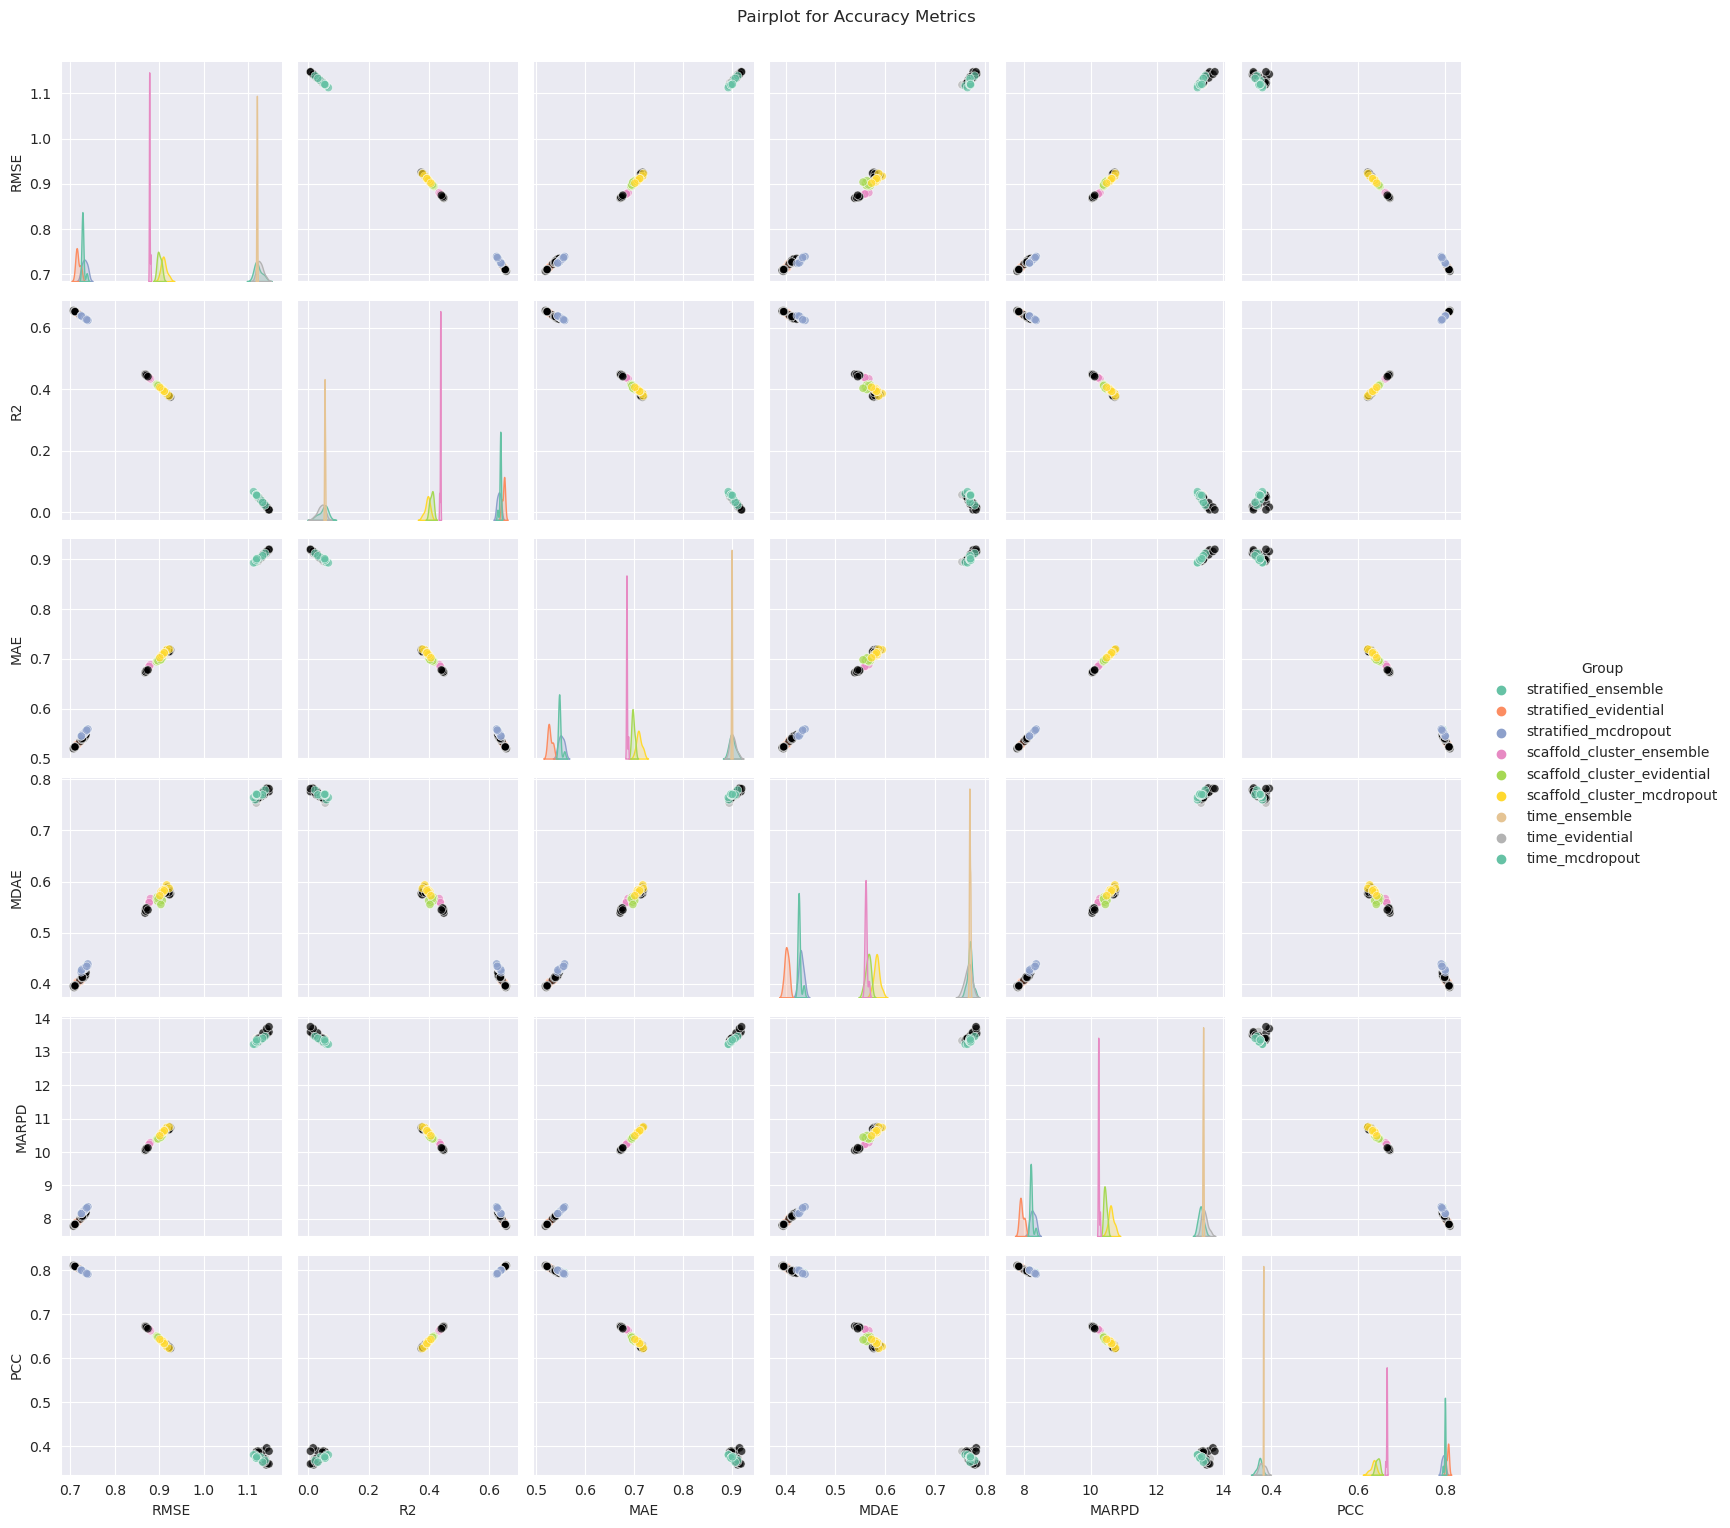

In [28]:
plot_pairplot(df_pcm, 'Pairplot for Accuracy Metrics', accmetrics, save_dir=save_dir, cmap="Set2")

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/bkhalil/miniconda3/envs/uqdd-118/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a 

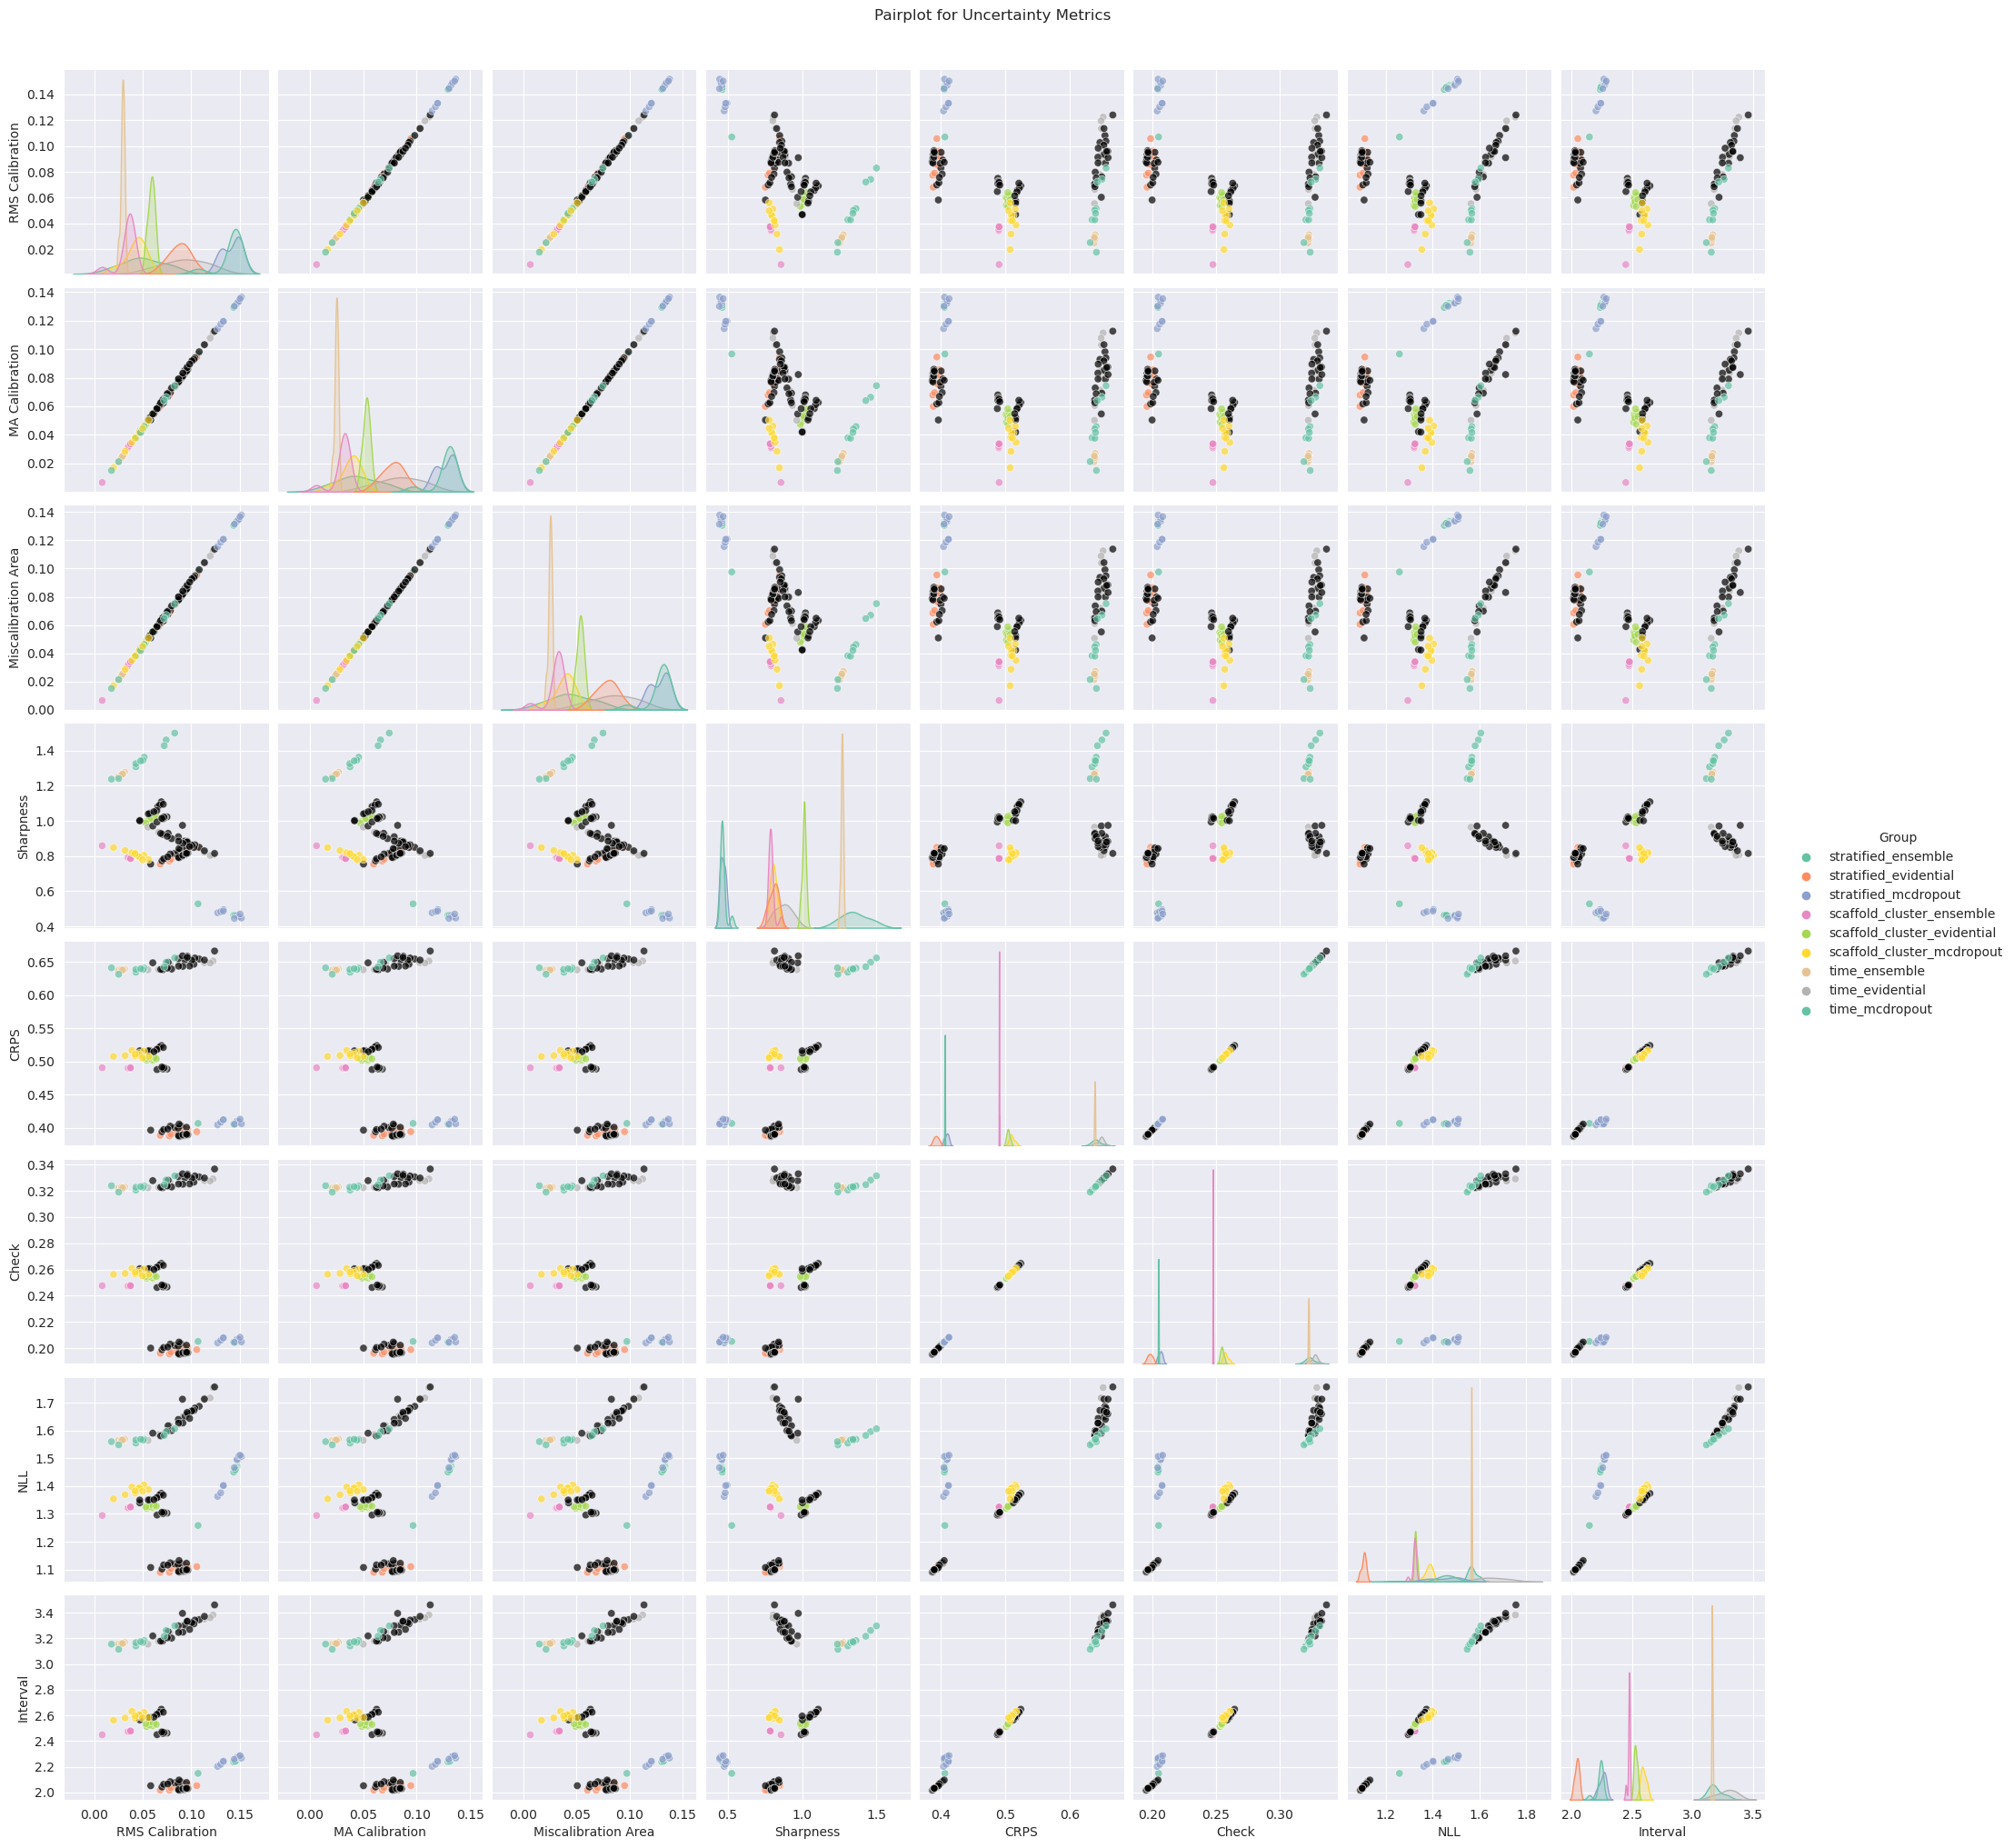

In [29]:
plot_pairplot(df_pcm, 'Pairplot for Uncertainty Metrics', uctmetrics, save_dir=save_dir, cmap="Set2")

## Finding Highly correlated metrics

In [42]:
def find_highly_correlated_metrics(df, metrics, threshold=0.8, save_dir=None, cmap="coolwarm"):
    # Calculate the correlation matrix
    corr_matrix = df[metrics].corr().abs()

    # Find pairs of metrics with correlation above the threshold
    highly_correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                highly_correlated_pairs.append(pair)

    # Print the highly correlated pairs
    print("Highly correlated metrics (correlation coefficient > {}):".format(threshold))
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap=cmap)
    plt.title("Correlation Matrix")
    metrics_names = "_".join(metrics)
    plot_name = f"correlation_matrix_{threshold}_{metrics_names}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

    return highly_correlated_pairs

Highly correlated metrics (correlation coefficient > 0.9):
R2 and RMSE: 1.00
MAE and RMSE: 1.00
MAE and R2: 1.00
MDAE and RMSE: 0.99
MDAE and R2: 0.99
MDAE and MAE: 1.00
MARPD and RMSE: 1.00
MARPD and R2: 1.00
MARPD and MAE: 1.00
MARPD and MDAE: 1.00
PCC and RMSE: 1.00
PCC and R2: 1.00
PCC and MAE: 1.00
PCC and MDAE: 0.99
PCC and MARPD: 1.00


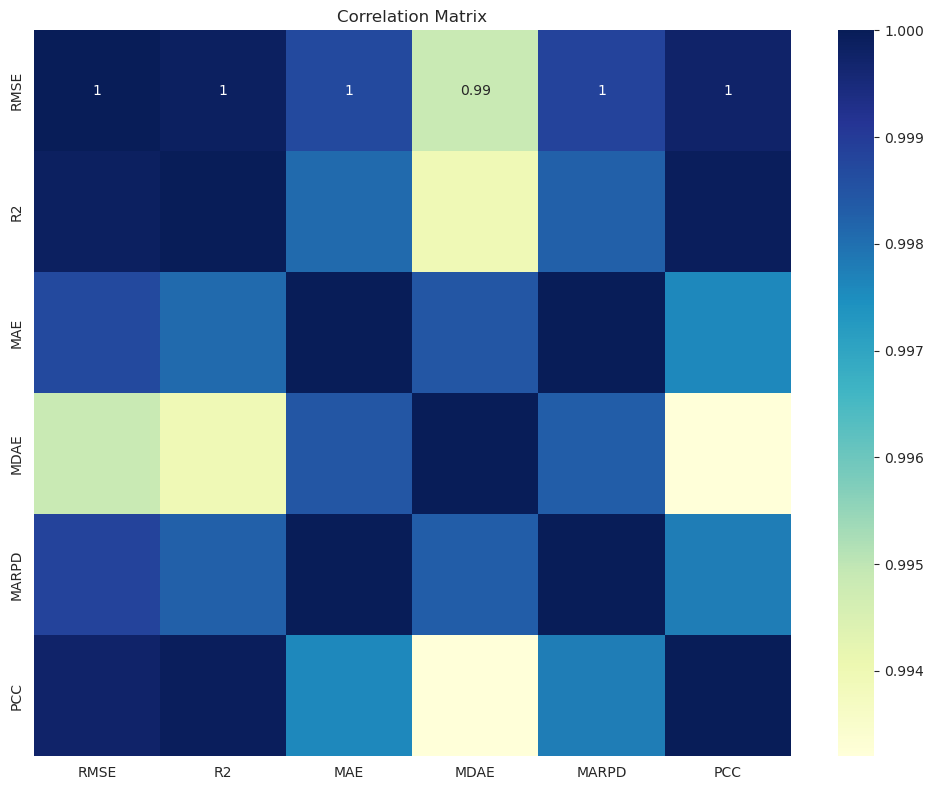

In [16]:
save_dir=None
highly_correlated_metrics = find_highly_correlated_metrics(df_pcm, accmetrics, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")

Highly correlated metrics (correlation coefficient > 0.9):
MA Calibration and RMS Calibration: 1.00
Miscalibration Area and RMS Calibration: 1.00
Miscalibration Area and MA Calibration: 1.00
Check and CRPS: 1.00
Interval and CRPS: 0.96
Interval and Check: 0.96


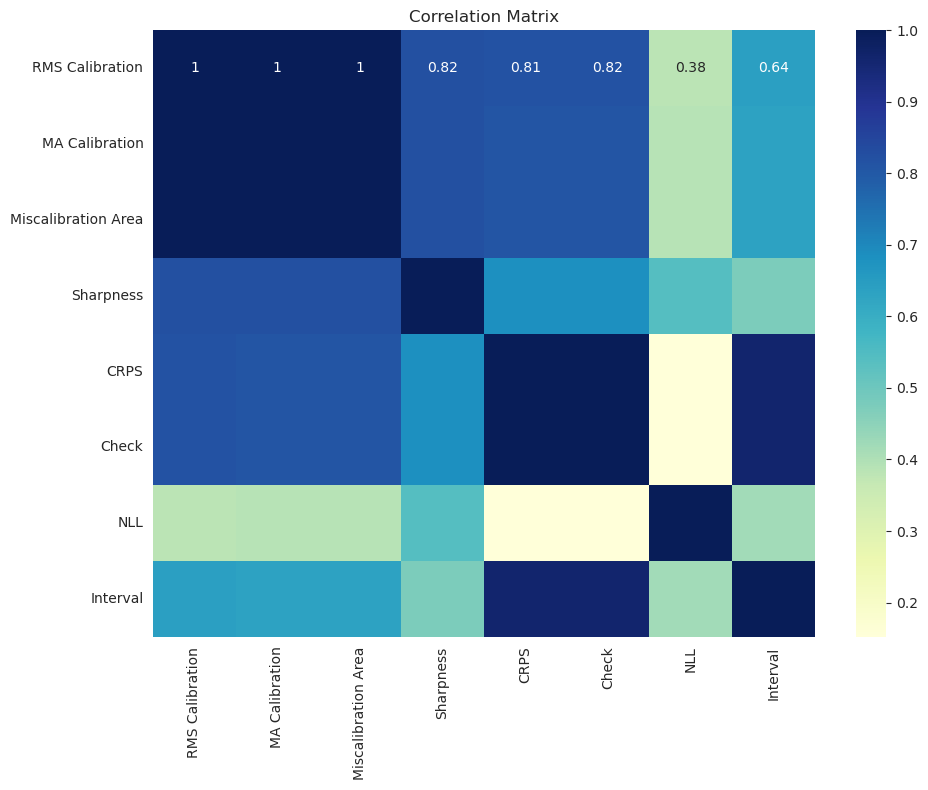

In [17]:
highly_correlated_uctmetrics = find_highly_correlated_metrics(df_pcm, uctmetrics, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")

Highly correlated metrics (correlation coefficient > 0.9):
Interval and CRPS: 0.99
Interval and NLL: 0.90


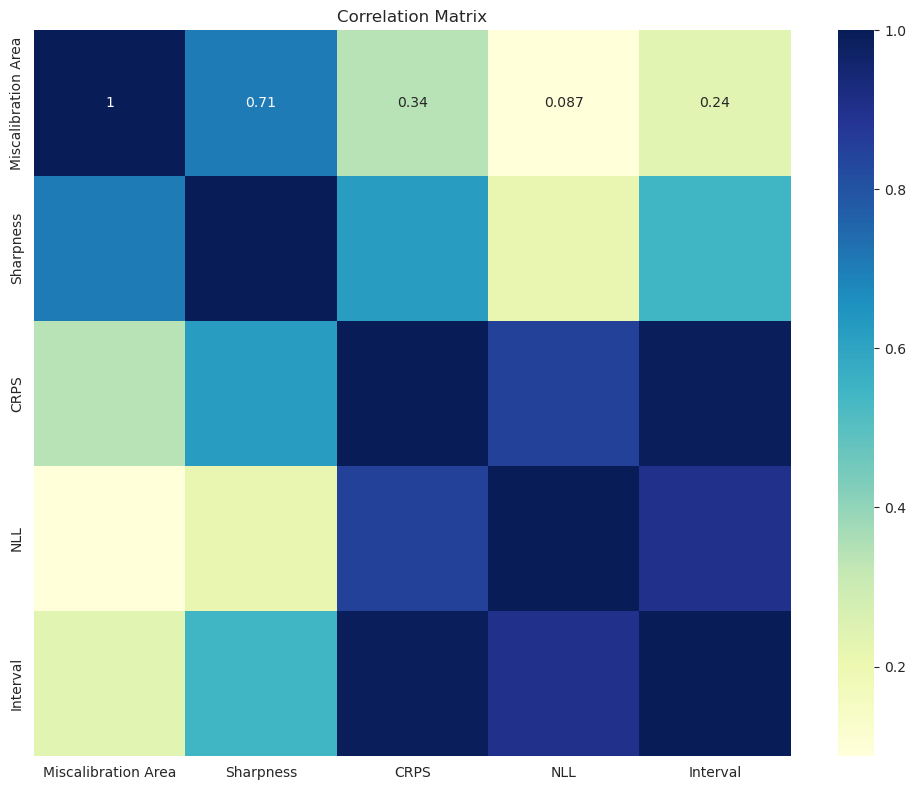

In [51]:
uctmetrics_uncorr = ['Miscalibration Area', 'Sharpness', 'CRPS', 'NLL', 'Interval']
highly_correlated_uctmetrics_uncorr = find_highly_correlated_metrics(df_pcm, uctmetrics_uncorr, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")

In [ ]:
plot_pairplot(df_pcm, 'Pairplot for Highly Uncorrelated Uncertainty Metrics', uctmetrics_uncorr, save_dir=save_dir, cmap="Set2")

## Bar plots of metrics:
This includes the accuracy metrics and the uncertainty metrics
For all the metrics and also for the highly uncorrelated ones

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


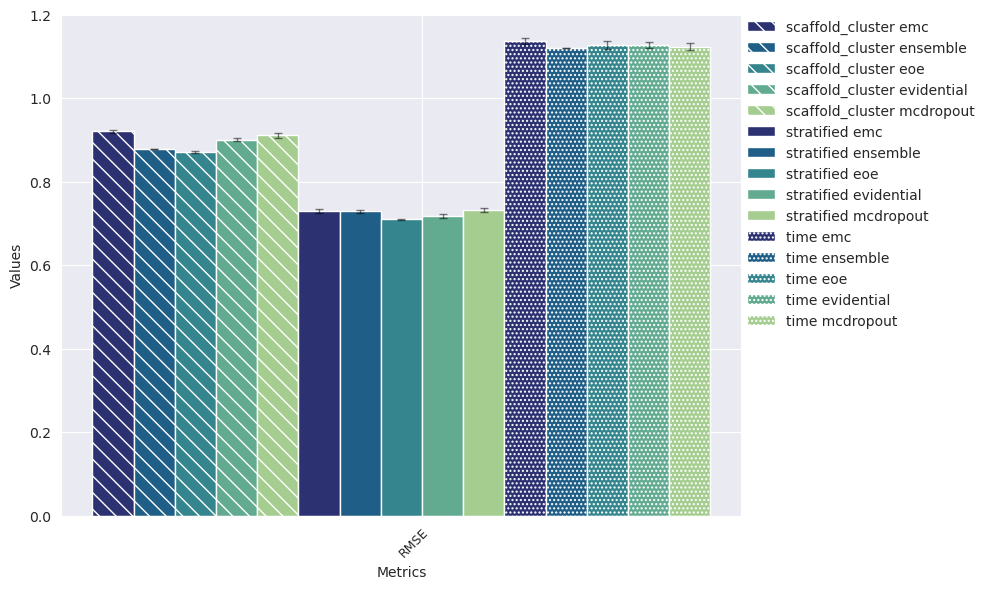

In [48]:
plot_metrics(df_pcm, ["RMSE"], cmap="crest_r", save_dir=save_dir)

In [ ]:
plot_metrics(df_pcm, accmetrics, cmap="crest_r", save_dir=save_dir)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


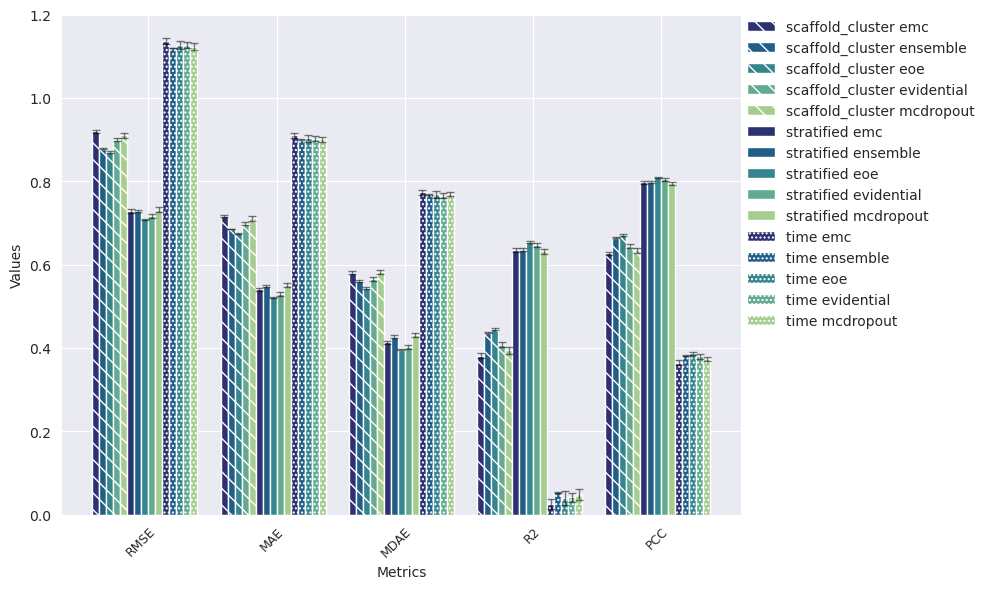

In [49]:
accmetrics = ['RMSE', 'MAE', 'MDAE', 'R2', 'PCC']
plot_metrics(df_pcm, accmetrics, cmap="crest_r", save_dir=save_dir)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


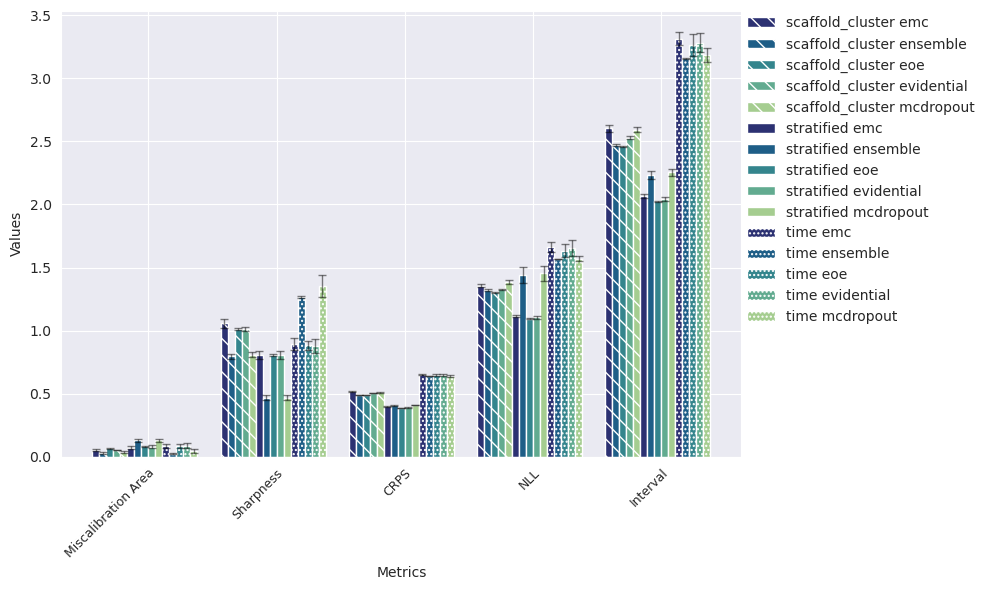

In [52]:
plot_metrics(df_pcm, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir)

In [ ]:
plot_metrics(df_pcm, ["Interval"], cmap="crest_r", save_dir=save_dir)

In [ ]:
plot_metrics(df_pcm, ["Miscalibration Area"], cmap="crest_r", save_dir=save_dir)

## Calibration comparisons

In [16]:
def plot_comparison_metrics(df, metrics, cmap="crest_r", save_dir=None):  #, draw_points_on_error_bars=False
    stats_dfs = []

    # Prepare data for each metric
    for metric in metrics:
        mean_df = (
            df.loc[:, ["Split", "Model type", "Calibration", metric]]
            .groupby(["Split", "Model type", "Calibration"])
            .mean()
            .rename(columns={metric: f"{metric}_mean"})
        )
        std_df = (
            df.loc[:, ["Split", "Model type", "Calibration", metric]]
            .groupby(["Split", "Model type", "Calibration"])
            .std()
            .rename(columns={metric: f"{metric}_std"})
        )
        stats_df = (
            pd.merge(mean_df, std_df, on=["Split", "Model type", "Calibration"])
            .sort_values(["Split", "Model type", "Calibration"])
            .reset_index()
            .assign(Group=lambda df: df.apply(lambda row: f"{row['Split']}_{row['Model type']}_{row['Calibration']}", axis=1))
        )
        stats_df['Metric'] = metric
        stats_dfs.append(stats_df)

    combined_stats_df = pd.concat(stats_dfs)

    scalar_mappable = ScalarMappable(cmap=cmap)
    model_types = combined_stats_df["Model type"].unique()
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}

    hatches_dict = {
        "Before Calibration": "\\\\",
        "After Calibration": "",
    }
    
    # Calculate appropriate figsize based on the number of metrics
    fig_width = max(7, len(metrics) * 3)
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    bar_width = 0.1
    group_spacing = 0.2  # Adjusted for closer split groups
    split_spacing = 0.6
    num_bars = len(model_types) * 2  # 2 calibration statuses (Before and After)
    positions = []
    tick_positions = []
    tick_labels = []

    for i, metric in enumerate(metrics):
        metric_data = combined_stats_df[combined_stats_df['Metric'] == metric]
        split_types = metric_data["Split"].unique()
        for j, split in enumerate(split_types):
            split_data = metric_data[metric_data["Split"] == split]
            for k, model_type in enumerate(model_types):
                for l, calibration in enumerate(["Before Calibration", "After Calibration"]):
                    position = (i * (split_spacing + len(split_types) * (num_bars * bar_width + group_spacing)) + 
                                j * (num_bars * bar_width + group_spacing) + 
                                k * 2 * bar_width + l * bar_width)
                    positions.append(position)
                    height = split_data[(split_data["Model type"] == model_type) & (split_data["Calibration"] == calibration)][f"{metric}_mean"].values[0]
                    ax.bar(
                        position,
                        height=height, 
                        color=color_dict[model_type],
                        hatch=hatches_dict[calibration],
                        width=bar_width,
                    )
                    # # Draw point on the error bar
                    # if draw_points_on_error_bars:
                    #     ax.plot(position, height, 'o', color='black')
            # Add tick positions and labels for each split within each metric
            center_position = (i * (split_spacing + len(split_types) * (num_bars * bar_width + group_spacing)) + 
                               j * (num_bars * bar_width + group_spacing) + 
                               (num_bars * bar_width) / 2)
            tick_positions.append(center_position)
            tick_labels.append(f"{metric}\n{split}")

    def create_stats_legend(color_dict, hatches_dict):
        patches = []
        for label, color in color_dict.items():
            patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
        for label, hatch in hatches_dict.items():
            patches.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatch, label=label))
        return patches

    legend_elements = create_stats_legend(color_dict, hatches_dict)

    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.0, 1.0),
        loc="upper left",
        borderaxespad=0,
        frameon=False,
    )

    for (_, row), bar in zip(combined_stats_df.iterrows(), ax.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()
        # print(row[f"{row['Metric']}_std"])
        yerr_lower = y_bar - max(0, y_bar - row[f"{row['Metric']}_std"])
        yerr_upper = row[f"{row['Metric']}_std"]
        ax.errorbar(
            x_bar,
            y_bar,
            # yerr=row[f"{row['Metric']}_std"],
            yerr=[[yerr_lower], [yerr_upper]], 
            color="black",
            # fmt='o' if draw_points_on_error_bars else 'none',  # Option to draw points on error bars
            fmt="none",  # Option to draw points on error bars
            elinewidth=1,
            capsize=3,
            alpha=0.5,
            
        )

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Metrics and Splits")
    ax.set_ylabel("Values")
    metrics_names = "_".join(metrics)
    plot_name = f"comparison_barplot_{cmap}_{metrics_names}"
    # plot_name += "_points" if draw_points_on_error_bars else ""
    save_plot(fig, save_dir, plot_name)
    plt.show()
    plt.close()


In [ ]:
plot_comparison_metrics(df_calib, ['RMS Calibration', 'MA Calibration', 'Miscalibration Area'], cmap="crest_r", save_dir=save_dir)

In [ ]:
plot_comparison_metrics(df_calib, ['Miscalibration Area'], cmap="crest_r", save_dir=save_dir)

In [ ]:
plot_comparison_metrics(df_calib, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir)

In [ ]:
# df_calib.head(100)

## Accuracy Rejection Curves

In [ ]:
save_dir

In [23]:
def load_predictions(save_dir, model_name):
    preds_path = os.path.join(save_dir, model_name, 'preds.pkl')
    return pd.read_pickle(preds_path)

In [24]:
mname = df_pcm.iloc[0]['model name']
print(mname)
preds = load_predictions(save_dir, mname)

20240625-papyrus_xc50_evidential_random_ankh-large_ecfp2048_volcanic-shape-66


In [25]:
preds.head()

,y_true,y_pred,y_eps,y_err,y_alea
0,9.602,8.606810,0.890098,-0.995191,2.262495
1,5.223,6.252293,0.805469,1.029293,2.079237
2,7.208,7.166993,0.855251,-0.041007,2.177103
3,5.328,5.173752,0.704535,-0.154248,1.933591
4,6.730,6.699798,0.812665,-0.030202,2.084458


In [26]:
# # BACKUP
# from sklearn.metrics import mean_squared_error, auc
# 
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred', normalize_rmse=False, random_rejection=False):
#     if random_rejection:
#         preds = preds.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame randomly
#     else:
#         preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     # preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_steps = np.arange(0, len(preds), step=int(len(preds) * 0.01))
#     rejection_rates = rejection_steps / len(preds)
#     rmses = []
#     
#     initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
# 
#     for i in rejection_steps:
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         if normalize_rmse:
#             rmse /= initial_rmse
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=False):
#     stats_dfs = []
#     # model_types = df_pcm["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             aggregated_rmses = []
#             auc_values = []
# 
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds, normalize_rmse=normalize_rmse)
#                 aggregated_rmses.append(rmses)
#                 auc_values.append(auc_arc)
# 
#             # Average RMSE values across models
#             mean_rmses = np.mean(aggregated_rmses, axis=0)
#             std_rmses = np.std(aggregated_rmses, axis=0)
# 
#             # Plot the aggregated RMSE-Rejection curve
#             ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-RRC: {np.mean(auc_values):.2f})", color=color_dict[model_type])
#             ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-RRC_mean': mean_auc, 'AUC-RRC_std': std_auc})
#     
#     # # Plot the baseline random rejection curve
#     # aggregated_rmses_random = []
#     # auc_values_random = []
#     # for model_name in df_pcm["model name"].unique():
#     #     preds = load_predictions(models_dir, model_name)
#     #     rejection_rates, rmses_random, auc_rrc_random = calculate_rmse_rejection_curve(preds, random_rejection=True)
#     #     aggregated_rmses_random.append(rmses_random)
#     #     auc_values_random.append(auc_rrc_random)
#     # mean_rmses_random = np.mean(aggregated_rmses_random, axis=0)
#     # std_rmses_random = np.std(aggregated_rmses_random, axis=0)
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE" if not normalize_rmse else "Normalized RMSE")
#     ax.set_title("RMSE-Rejection Curves" if not normalize_rmse else "Normalized RMSE-Rejection Curves")
#     ax.set_ylim(0.75,1.05) if normalize_rmse else None
#     ax.set_xlim(0, 1) # Rejection rate from 0 to 1
#     # Custom legend order
#     handles, labels = ax.get_legend_handles_labels()
#     ordered_labels = [f"{model_type}-" for model_type in model_types]
#     ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
#     ax.legend(handles=ordered_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
#     # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     # plot_name += "_normalized" if normalize_rmse else ""
#     save_plot(fig, save_dir_plot, plot_name, tighten=True)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)
# 
# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title=""):
#     # model_types = stats_df["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
# 
#     splits = stats_df["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-RRC_mean'].values[0]
#             yerr = model_data['AUC-RRC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 # center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-RRC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     save_plot(fig, save_dir, plot_name, tighten=True)
#     plt.show()
#     plt.close()

In [92]:
from sklearn.metrics import mean_squared_error, auc

def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred', normalize_rmse=False, random_rejection=False, unc_type=None, max_rejection_ratio=0.95):
    # First we choose which type of uncertainty to use
    if unc_type == 'aleatoric':
        uncertainty_col = 'y_alea'
    elif unc_type == 'epistemic':
        uncertainty_col = 'y_eps'
    elif unc_type == 'both':
        preds['y_unc'] = preds['y_alea'] + preds['y_eps']
        uncertainty_col = 'y_unc'
    elif unc_type is None and uncertainty_col in preds.columns:
        pass
    else:
        raise ValueError(f"Either provide valid uncertainty type or provide the uncertainty column name in the DataFrame"
                         f"unc_type: {unc_type}, uncertainty_col: {uncertainty_col}")
    
    # Sort the DataFrame based on the uncertainty column or shuffle it randomly
    if random_rejection:
        preds = preds.sample(frac=max_rejection_ratio).reset_index(drop=True)  # Shuffle the DataFrame randomly
    else:
        preds = preds.sort_values(by=uncertainty_col, ascending=False)
    
    max_rejection_index = int(len(preds) * max_rejection_ratio)
    rejection_steps = np.arange(0, max_rejection_index, step=int(len(preds) * 0.01))
    rejection_rates = rejection_steps / len(preds)
    rmses = []
    
    initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
    
    # RRC calculation
    for i in rejection_steps:
        selected_preds = preds.iloc[i:]
        rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
        if normalize_rmse:
            rmse /= initial_rmse
        rmses.append(rmse)
    # AUC calculation
    auc_arc = auc(rejection_rates, rmses)
    
    return rejection_rates, rmses, auc_arc


def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=False, unc_type='aleatoric', max_rejection_ratio=0.95):
    assert unc_type in ['aleatoric', 'epistemic', 'both'], "unc_type should be either 'aleatoric' or 'epistemic' or 'both'"
    unc_col = 'y_alea' if unc_type == 'aleatoric' else 'y_eps'
    stats_dfs = []
    model_types = ["ensemble", "evidential", "mcdropout"]
    splits = df_pcm["Split"].unique()
    
    scalar_mappable = ScalarMappable(cmap=cmap)
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}

    fig, ax = plt.subplots(figsize=(12, 8))

    for model_type in model_types:
        for split in splits:
            model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
            aggregated_rmses = []
            auc_values = []
            
            for model_name in model_names:
                preds = load_predictions(models_dir, model_name)
                rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds, uncertainty_col=unc_col, normalize_rmse=normalize_rmse, max_rejection_ratio=max_rejection_ratio)
                aggregated_rmses.append(rmses)
                auc_values.append(auc_arc)

            # Average RMSE values across models
            mean_rmses = np.mean(aggregated_rmses, axis=0)
            std_rmses = np.std(aggregated_rmses, axis=0)
            
            mean_auc = np.mean(auc_values)
            std_auc = np.std(auc_values)
            
            # Plot the aggregated RMSE-Rejection curve
            ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-RRC:{mean_auc:.3f} ($\sigma${std_auc:.3f}))", color=color_dict[model_type])
            ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
            
            # Store aggregated AUC values
            stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-RRC_mean': mean_auc, 'AUC-RRC_std': std_auc})
    
    # Plot the baseline random rejection curve
    for split in splits:
        model_names = df_pcm[df_pcm["Split"] == split]["model name"].unique()
        aggregated_rmses_random = []
        auc_values_random = []
        # for model_name in df_pcm["model name"].unique():
        for model_name in model_names:
            preds = load_predictions(models_dir, model_name)
            rejection_rates, rmses_random, auc_rrc_random = calculate_rmse_rejection_curve(preds, uncertainty_col=unc_col, random_rejection=True, normalize_rmse=normalize_rmse, max_rejection_ratio=max_rejection_ratio)
            aggregated_rmses_random.append(rmses_random)
            auc_values_random.append(auc_rrc_random)
        mean_rmses_random = np.mean(aggregated_rmses_random, axis=0)
        std_rmses_random = np.std(aggregated_rmses_random, axis=0)
        
        mean_auc_random = np.mean(auc_values_random)
        std_auc_random = np.std(auc_values_random)
        
        ax.plot(rejection_rates, mean_rmses_random, label=f"random-reject-{split} (AUC-RRC:{mean_auc_random:.3f} ($\sigma${std_auc_random:.3f}))", color='black', linestyle='--')
        ax.fill_between(rejection_rates, mean_rmses_random - std_rmses_random, mean_rmses_random + std_rmses_random, color='grey', alpha=0.2)
        
        stats_dfs.append({'Model type': 'random', 'Split': split, 'AUC-RRC_mean': mean_auc_random, 'AUC-RRC_std': std_auc_random})
        
    ax.set_xlabel("Rejection Rate")
    ax.set_ylabel("RMSE" if not normalize_rmse else "Normalized RMSE")
    ax.set_title("RMSE-Rejection Curves" if not normalize_rmse else "Normalized RMSE-Rejection Curves")
    ax.set_ylim(0.75,1.05) if normalize_rmse else None
    ax.set_xlim(0, max_rejection_ratio) # Rejection rate from 0 to 1
    ax.set_xticks(np.append(np.arange(0, max_rejection_ratio+0.05, 0.1), max_rejection_ratio))
    # ax.set_yticks(np.arange(0.75, 1.05, 0.05))
    # Custom legend order
    # handles, labels = ax.get_legend_handles_labels()
    # stratified_handles = [h for h, l in zip(handles, labels) if 'stratified' in l]
    # scaffold_handles = [h for h, l in zip(handles, labels) if 'scaffold_cluster' in l]
    # ordered_handles = [item for pair in zip(stratified_handles, scaffold_handles) for item in pair]
    # ordered_handles += [h for h, l in zip(handles, labels) if 'Random' in l]  # Add random baseline last
    #     
    # ax.legend(
    #     ordered_handles,
    #     bbox_to_anchor=(0, 0),  # Place the legend inside the plot area, bottom-left corner
    #     loc='lower left',       # Align the legend to the lower left
    #     borderaxespad=0,        # No padding between legend and axes
    #     frameon=False,          # No frame around the legend
    #     fontsize='small',       # Adjust font size
    #     # ncol=2                  # Number of columns in the legend
    # )
    # Custom legend order
    handles, labels = ax.get_legend_handles_labels()
    ordered_labels = [f"{model_type}-" for model_type in model_types+["random"]]
    ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
    ax.legend(handles=ordered_handles, loc='lower left')
    
    plot_name = "rmse_rejection_curve"
    plot_name += f"_{add_to_title}" if add_to_title else ""
    save_plot(fig, save_dir_plot, plot_name, tighten=True)
    
    plt.show()

    return pd.DataFrame(stats_dfs)

def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title=""):
    model_types = ["ensemble", "evidential", "mcdropout", "random"]  # Ordered model types including Random

    splits = stats_df["Split"].unique()
    
    scalar_mappable = ScalarMappable(cmap=cmap)
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
    color_dict["random"] = 'black'  # Color for Random baseline

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    group_spacing = 0.6
    num_bars = len(model_types)
    positions = []
    tick_positions = []
    tick_labels = []

    for i, split in enumerate(splits):
        split_data = stats_df[stats_df['Split'] == split]
        for j, model_type in enumerate(model_types):
            model_data = split_data[split_data['Model type'] == model_type]
            position = i * (num_bars * bar_width + group_spacing) + j * bar_width
            positions.append(position)
            height = model_data['AUC-RRC_mean'].values[0]
            yerr = model_data['AUC-RRC_std'].values[0]
            ax.bar(
                position,
                height=height,
                yerr=yerr,
                color=color_dict[model_type],
                width=bar_width,
                label=model_type if i == 0 else ""
            )
            # Add tick positions and labels
            if j == len(model_types) - 1:
                center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
                tick_positions.append(center_position)
                tick_labels.append(f"{split}")

    def create_stats_legend(color_dict):
        patches = []
        for label, color in color_dict.items():
            patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
        return patches

    legend_elements = create_stats_legend(color_dict)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Splits")
    ax.set_ylabel("AUC-RRC")
    ax.set_ylim(0.5, 1.0)
    
    plot_name = f"auc_comparison_barplot_{cmap}"
    plot_name += f"_{add_to_title}" if add_to_title else ""
    save_plot(fig, save_dir, plot_name, tighten=True)
    plt.show()
    plt.close()

# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title=""):
#     # model_types = stats_df["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
# 
#     splits = stats_df["Split"].unique()
# 
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-RRC_mean'].values[0]
#             yerr = model_data['AUC-RRC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 # center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-RRC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     save_plot(fig, save_dir, plot_name, tighten=True)
#     plt.show()
#     plt.close()

In [93]:
df_pcm_stratified = df_pcm[df_pcm['Split'] == 'stratified']
df_pcm_scaffold = df_pcm[df_pcm['Split'] == 'scaffold_cluster']
print(df_pcm_stratified.shape, df_pcm_scaffold.shape)

(30, 41) (30, 41)


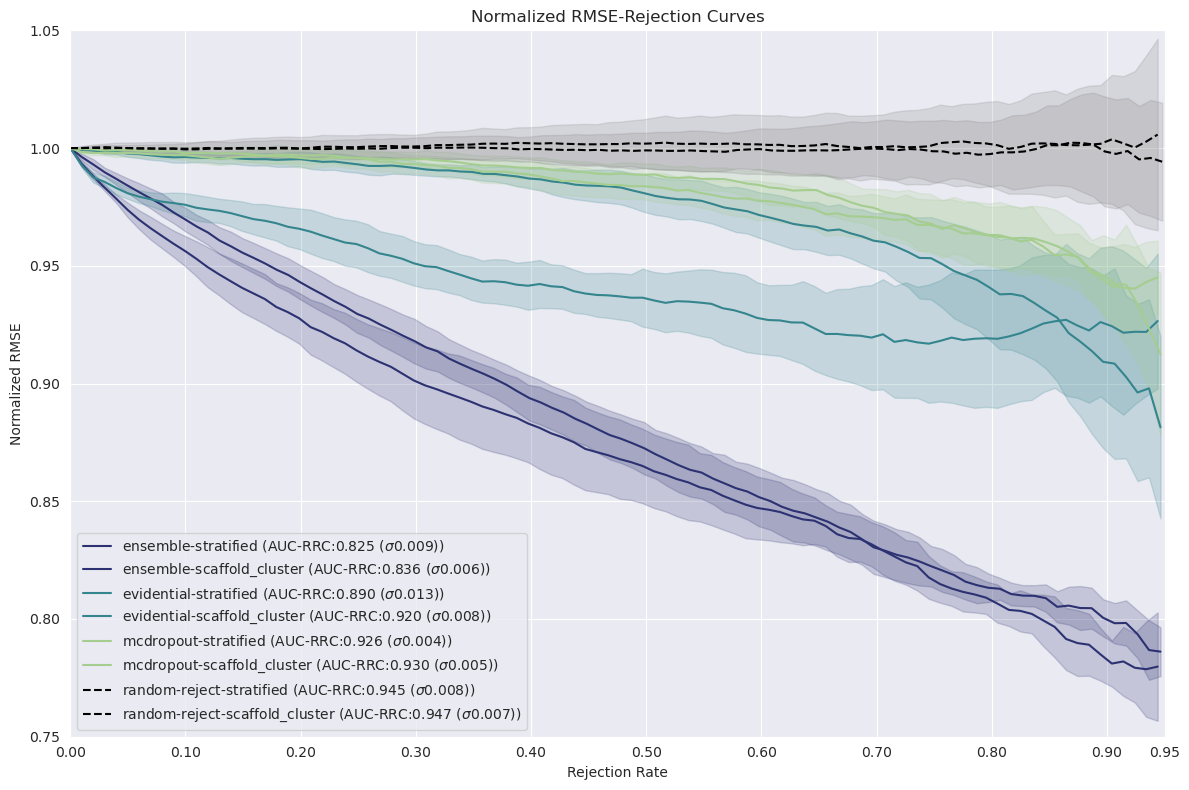

In [89]:
stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=True, unc_type='aleatoric', max_rejection_ratio=0.95)

In [53]:
stats_df.head(10)

,Model type,Split,AUC-RRC_mean,AUC-RRC_std
0,ensemble,stratified,0.824802,0.008691
1,ensemble,scaffold_cluster,0.836012,0.006410
2,evidential,stratified,0.890142,0.012977
3,evidential,scaffold_cluster,0.920013,0.008152
4,mcdropout,stratified,0.925732,0.003991
5,mcdropout,scaffold_cluster,0.930198,0.004556
6,random,stratified,0.942251,0.006792
7,random,scaffold_cluster,0.947428,0.005867


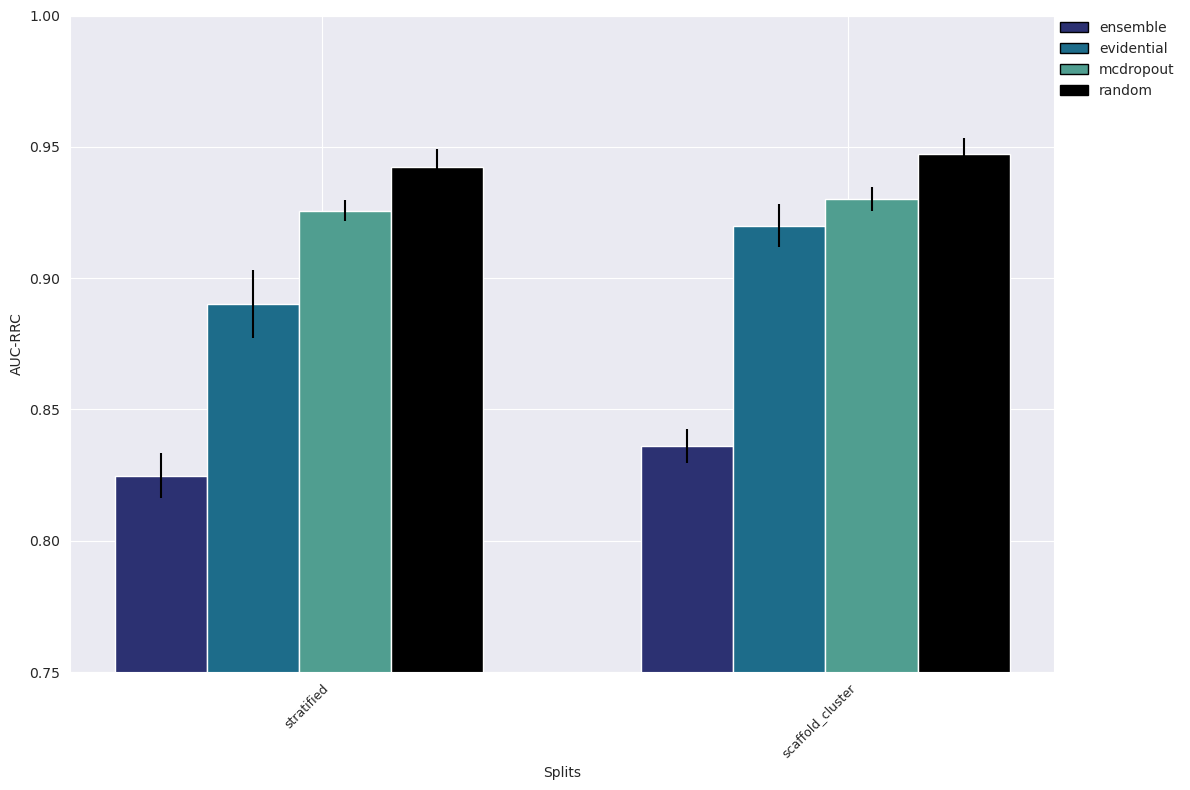

In [58]:
plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title="")

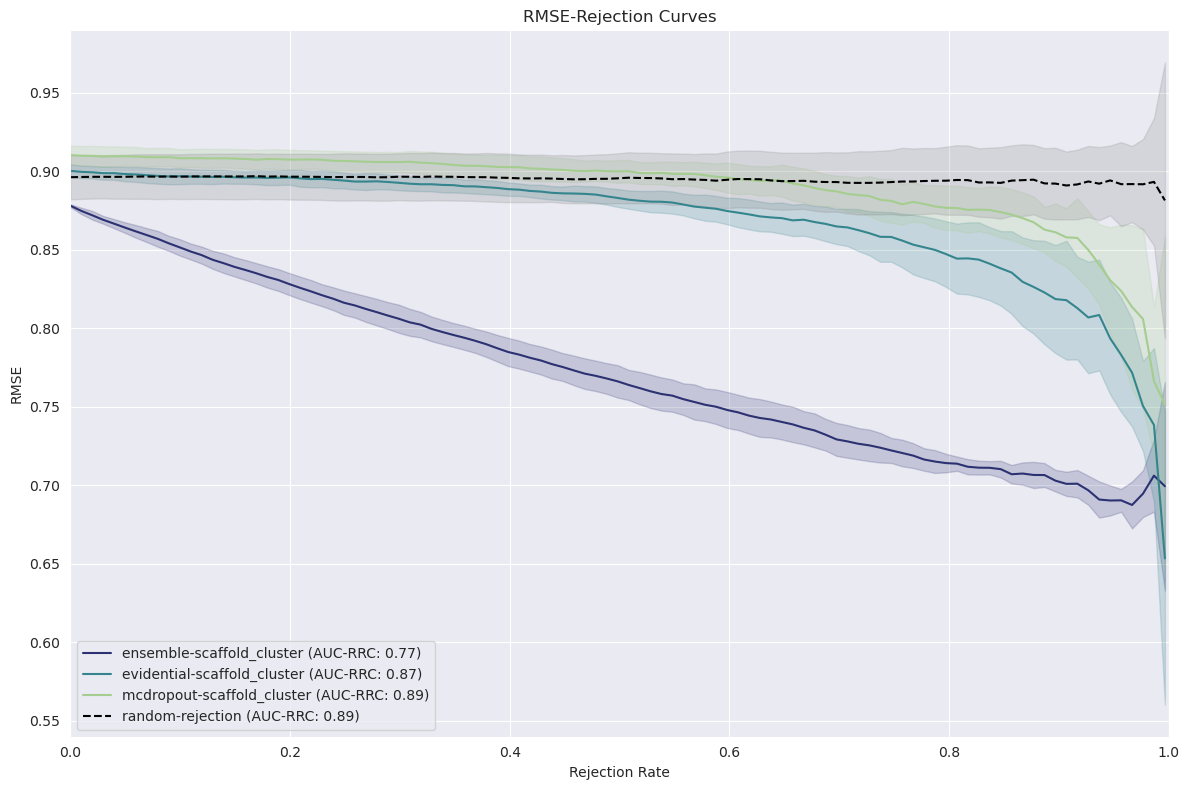

In [55]:
# stats_df = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified-normalized", normalize_rmse=True)
stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=False)

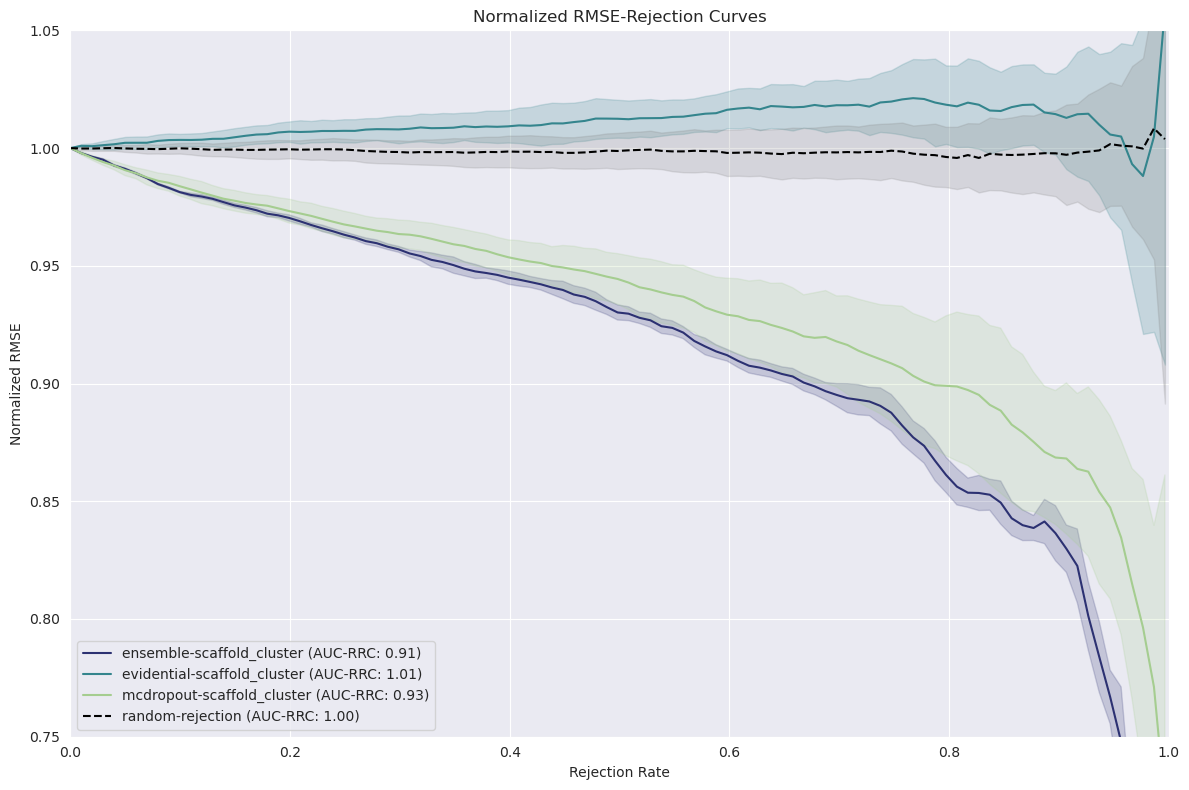

In [61]:
stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='epistemic')

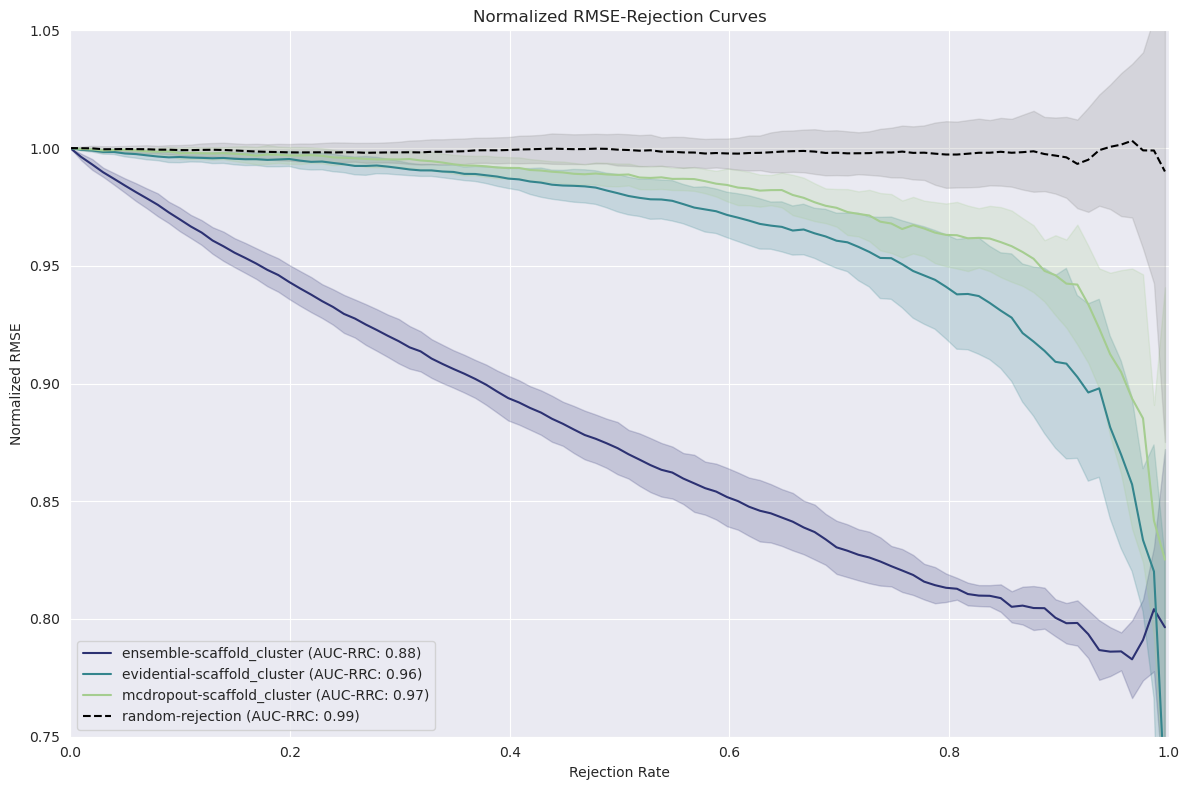

In [56]:
stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='aleatoric')

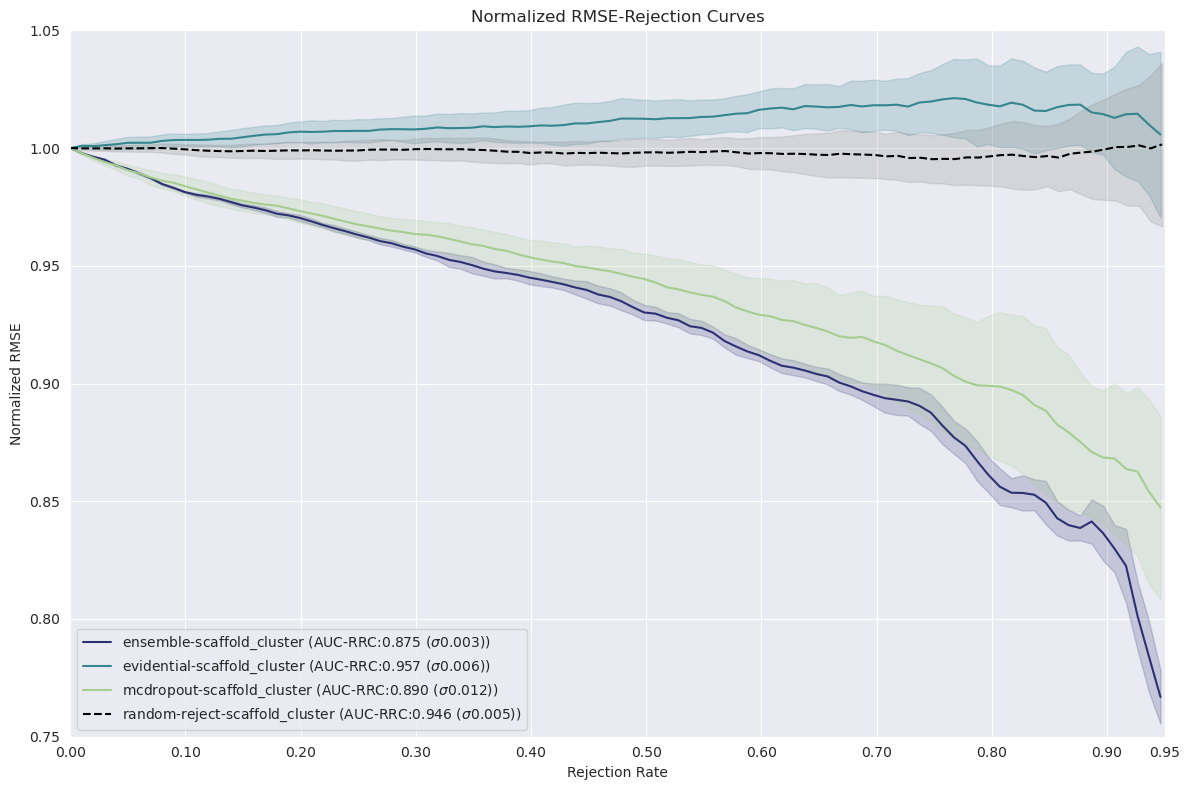

In [84]:
stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='both')

In [85]:
# we want to create a function to save stats_df to a csv file
def save_stats_df(stats_df, save_dir, add_to_title=""):
    stats_df.to_csv(os.path.join(save_dir, f"stats_df_{add_to_title}.csv"), index=False)
    
def load_stats_df(save_dir, add_to_title=""):
    return pd.read_csv(os.path.join(save_dir, f"stats_df_{add_to_title}.csv"))

In [ ]:
# for loop one normalized and one not
save_dir = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/'
save_dir_plot = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/rrcs/'
# make dir if not exist
os.makedirs(save_dir_plot, exist_ok=True)

for normalize_rmse in [True, False]:
    add_to_title = "-normalized" if normalize_rmse else ""
    stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title="all"+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95)
    plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title="all"+add_to_title)
    save_stats_df(stats_df, save_dir_plot, add_to_title="all"+add_to_title)
    for name, df in zip(["stratified", "scaffold"], [df_pcm_stratified, df_pcm_scaffold]):
        stats_df = plot_rmse_rejection_curves(df, save_dir, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title=name+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95)
        plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title=name+add_to_title)
        save_stats_df(stats_df, save_dir_plot, add_to_title=name+add_to_title)
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title=add_to_title, normalize_rmse=False)
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir, add_to_title="all")


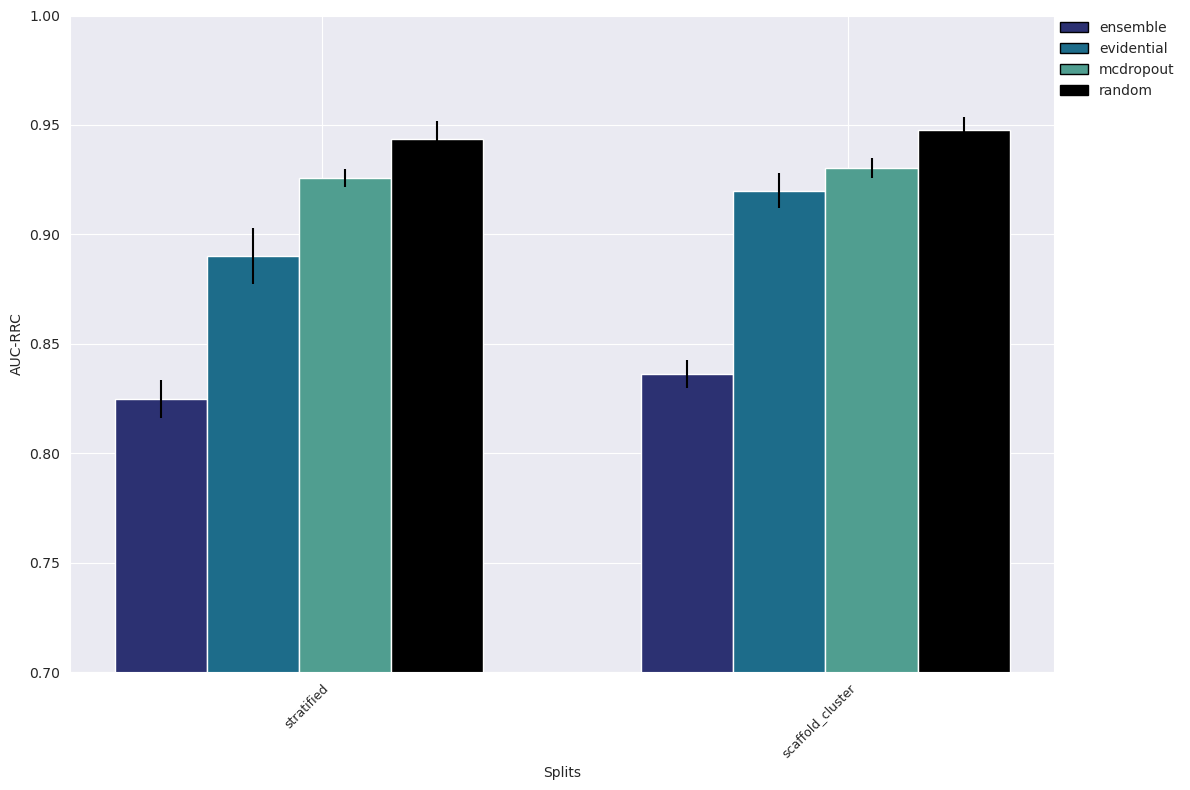

In [87]:
# load stats_df from stratified and scaffold normalized then combine them and create a bar plot for auc comparison with added tag "combined"
stats_df_stratified_normal = load_stats_df(save_dir_plot, add_to_title="stratified-normalized")
stats_df_scaled_normal = load_stats_df(save_dir_plot, add_to_title="scaffold-normalized")

plot_auc_comparison(pd.concat([stats_df_stratified_normal, stats_df_scaled_normal]), cmap="crest_r", save_dir=save_dir_plot, add_to_title="combined-normalized")


In [ ]:
# stats_df_normalized = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="all-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_normalized, cmap="crest_r", save_dir=save_dir, add_to_title="all-normal")

In [ ]:
# stats_df_stratified = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified", normalize_rmse=False)
# plot_auc_comparison(stats_df_stratified, cmap="crest_r", save_dir=save_dir, add_to_title="stratified")
# stats_df_stratified_normal = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_stratified_normal, cmap="crest_r", save_dir=save_dir, add_to_title="stratified-normal")

In [ ]:
# stats_df_scaled = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold", normalize_rmse=False)
# plot_auc_comparison(stats_df_scaled, cmap="crest_r", save_dir=save_dir, add_to_title="scaffold")
# stats_df_scaled_normal = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_scaled_normal, cmap="crest_r", save_dir=save_dir, add_to_title="scaffold-normal")

In [ ]:
plot_auc_comparison(pd.concat([stats_df_stratified_normal, stats_df_scaled_normal]), cmap="crest_r", save_dir=save_dir, add_to_title="combined")

In [ ]:
# plot_auc_comparison(stats_df_stratified, cmap="crest_r", save_dir=save_dir, add_to_title="stratified")

In [ ]:
# stats_df_scaffold = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold")

In [ ]:
# # TRIAL 2 with RMSE NORMALIZATION
# 
# def load_predictions(models_dir, model_name):
#     preds_path = os.path.join(models_dir, model_name, 'preds.pkl')
#     return pd.read_pickle(preds_path)
# 
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_steps = np.arange(0, len(preds), step=int(len(preds) * 0.05))
#     rejection_rates = rejection_steps / len(preds)
#     rmses = []
# 
#     initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
#     
#     for i in rejection_steps:
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         normalized_rmse = rmse / initial_rmse  # Normalize RMSE values to start at 1
#         rmses.append(normalized_rmse)
#         # rmses.append(rmse - initial_rmse)  # Normalize RMSE values
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             aggregated_rmses = []
#             auc_values = []
# 
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 aggregated_rmses.append(rmses)
#                 auc_values.append(auc_arc)
# 
#             # Average RMSE values across models
#             mean_rmses = np.mean(aggregated_rmses, axis=0)
#             std_rmses = np.std(aggregated_rmses, axis=0)
# 
#             # Plot the aggregated RMSE-Rejection curve
#             ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-ARC: {np.mean(auc_values):.2f})", color=color_dict[model_type])
#             ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("Normalized RMSE")
#     ax.set_title("Normalized RMSE-Rejection Curves")
# 
#     # Custom legend order
#     handles, labels = ax.get_legend_handles_labels()
#     ordered_labels = [f"{model_type}-" for model_type in model_types]
#     ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
#     ax.legend(handles=ordered_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# from sklearn.metrics import mean_squared_error, auc
# 
# # def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
# #     preds = preds.sort_values(by=uncertainty_col, ascending=False)
# #     rejection_rates = np.linspace(0, 1, len(preds))
# #     rmses = []
# # 
# #     for i in range(len(preds)):
# #         selected_preds = preds.iloc[i:]
# #         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col]) #, squared=False
# #         rmses.append(rmse)
# # 
# #     auc_arc = auc(rejection_rates, rmses)
# #     print(auc_arc)
# #     return rejection_rates, rmses, auc_arc
# 
# 
# def plot_accuracy_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#                 # break
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     # if save_dir_plot:
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()

In [ ]:
# plot_accuracy_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_rates = np.linspace(0, 1, len(preds))
#     rmses = []
# 
#     for i in range(len(preds)):
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             auc_values = []
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 auc_values.append(auc_arc)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_rates = np.linspace(0, 1, len(preds))
#     rmses = []
# 
#     for i in range(len(preds)):
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             auc_values = []
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 auc_values.append(auc_arc)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None):
#     model_types = stats_df["Model type"].unique()
#     splits = stats_df["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-ARC_mean'].values[0]
#             yerr = model_data['AUC-ARC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-ARC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     save_plot(fig, save_dir, plot_name)
#     plt.show()
#     plt.close()

In [ ]:
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None)

In [ ]:
# df_before_calib['Calibration'] = 'Before Calibration'
# df_after_calib['Calibration'] = 'After Calibration'
# df_after_calib_std['Calibration'] = 'After Std Recalibrator'


# Accuracy Metrics

In [ ]:
# some vars
acc_metrics = ['RMSE', 'R2', 'MAE', 'MDAE', 'PCC']
uct_metrics_1 = ['RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness', 'CRPS', 'Check']
uct_metrics_2 = ['NLL', 'Interval']
save_dir = '/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-18-all-models/'
# save_dir = None

In [ ]:
plot_pairplot(df_before_calib, 'Pairplot for Accuracy Metrics', acc_metrics, save_dir=save_dir)

In [ ]:
acc_metrics = ['RMSE', 'R2', 'PCC']
plot_metrics(df_before_calib, 'Accuracy Metrics (Boxplot)', acc_metrics, plot_type='boxplot', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Bar plot)', acc_metrics, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Swarm plot)', acc_metrics, plot_type='swarm', save_dir=save_dir)


# Uncertainty Metrics

In [ ]:
plot_pairplot(df_before_calib, 'Pairplot for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
plot_pairwise_scatter_metrics(df_before_calib, 'Pairwise Scatter for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
uct_metrics_1 = ['Miscalibration Area', 'Sharpness', 'CRPS']
uct_metrics_2 = ['NLL', 'Interval']
uct_metrics = uct_metrics_1 + uct_metrics_2

In [ ]:
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


In [ ]:
# AFter Isotonic Regression
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)

# After Std Recalibrator
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


In [ ]:
# Define custom colors and hatches for models and splits
model_colors = {
    'evidential': 'skyblue',
    'mcdropout': 'orange',
    'ensemble': 'green'
}

split_hatches = {
    'random': '.',
    'scaffold_cluster': '//'
}

# Function to plot metrics with split type grouping
def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')

    plt.figure(figsize=(14, 7))

    if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
        plot_func = {
            'boxplot': sns.boxplot,
            'violin': sns.violinplot,
            'swarm': sns.swarmplot,
            'bar': sns.barplot
        }[plot_type]

        ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=model_colors.values(), order=metrics, hue_order=group_order)

        for patch, group in zip(ax.patches, melted_df['Group'].unique()):
            print(patch, group)
            split = 'random' if 'random' in group else 'scaffold_cluster'
            model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
            hatch = split_hatches[split]
            color = model_colors[model]
            print(split, model)
            print(color, hatch)

            patch.set_edgecolor(color)
            patch.set_facecolor(color)
            patch.set_hatch(hatch)


        # # Add textures to bars
        # for i, patch in enumerate(ax.patches):
        #     hatch = split_hatches['random' if 'random' in patch.get_label() else 'scaffold_cluster']
        #     patch.set_hatch(hatch)
        #     print(patch.get_label().split('_')[1])
        #     patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])
            # patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])

    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plot_name = f"{plot_type}_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot metrics with split type grouping
# def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
#     df = handle_inf_values(df)
#     melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
#     
#     plt.figure(figsize=(14, 7))
#     
#     if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
#         plot_func = {
#             'boxplot': sns.boxplot,
#             'violin': sns.violinplot,
#             'swarm': sns.swarmplot,
#             'bar': sns.barplot
#         }[plot_type]
# 
#         ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=list(model_colors.values()), order=metrics, hue_order=group_order)
# 
#         # Add textures to bars
#         for i, patch in enumerate(ax.patches):
#             group = melted_df['Group'].unique()[i // len(metrics)]
#             split = 'random' if 'random' in group else 'scaffold_cluster'
#             model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#             hatch = split_hatches[split]
#             color = model_colors[model]
#             
#             patch.set_edgecolor(color)
#             patch.set_facecolor(color)
#             patch.set_hatch(hatch)
# 
#     # Update legend to show both color and texture
#     handles, labels = ax.get_legend_handles_labels()
#     new_handles = []
#     new_labels = []
#     for handle, label in zip(handles, labels):
#         group = label
#         split = 'random' if 'random' in group else 'scaffold_cluster'
#         model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#         hatch = split_hatches[split]
#         color = model_colors[model]
#         patch = plt.Rectangle((0, 0), 1, 1, fc=color, hatch=hatch)
#         new_handles.append(patch)
#         new_labels.append(f"{model} ({split})")
#     
#     plt.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()
# 
#     plot_name = f"{plot_type}_{title.replace(' ', '_')}"
#     save_plot(plt.gcf(), save_dir, plot_name)


In [ ]:
plot_metrics(df_before_calib, 'Accuracy Metrics Before Calibration', acc_metrics, plot_type='bar', save_dir=None)

|# Comparing Calibration Metrics Before and After Calibration in one plot

In [ ]:
def plot_bar_uncertainty_metric_comparison(df, title, metric, plot_type="bar", group_order=group_order, save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group', 'Calibration'], value_vars=[metric], var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 7))
    if plot_type == 'bar':
        sns.barplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", errorbar='sd', dodge=True, order=group_order)
    elif plot_type == 'violin':
        sns.violinplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", inner="quart", dodge=True, order=group_order)
    elif plot_type == 'swarm':
        sns.swarmplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", dodge=True, order=group_order)
    sns.despine()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot_name = f"bar_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

In [ ]:
# Add a column to indicate calibration state
df_before_calib['Calibration'] = 'Before Calibration'
df_after_calib_iso['Calibration'] = 'After Isotonic Regression'
df_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
df_combined = pd.concat([df_before_calib, df_after_calib_iso, df_after_calib_std])

In [ ]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir)

In [ ]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir, plot_type="violin")

In [ ]:
# other metrics before and after
plot_bar_uncertainty_metric_comparison(df_combined, 'Sharpness Before and After Calibration', 'Sharpness', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'CRPS Before and After Calibration', 'CRPS', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'NLL Before and After Calibration', 'NLL', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'Interval Before and After Calibration', 'Interval', save_dir=save_dir)

# Special MC Dropout Experiment

In [ ]:
# Now we shall plot the same but to compare the MCDP results
plot_metrics(mcdp_before_calib, 'Accuracy Metrics Before Calibration (MCDP)', acc_metrics, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)

In [ ]:
# Pair plot
plot_pairplot(mcdp_before_calib, 'Pairplot for Accuracy Metrics (MCDP)', acc_metrics, save_dir=save_dir)

# Pair plot for Uncertainty Metrics
plot_pairplot(mcdp_before_calib, 'Pairplot for Uncertainty Metrics (MCDP)', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
# Comparing Calibration Metrics Before and After Calibration in one plot
# Add a column to indicate calibration state
mcdp_before_calib['Calibration'] = 'Before Calibration'
mcdp_after_calib_iso['Calibration'] = 'After Isotonic Regression'
mcdp_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
mcdp_combined = pd.concat([mcdp_before_calib, mcdp_after_calib_iso, mcdp_after_calib_std])

plot_bar_uncertainty_metric_comparison(mcdp_combined, 'Miscalibration Area Before and After Calibration (MCDP)', 'Miscalibration Area', save_dir=save_dir, group_order=mc_group_order)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Data preparation
data = {
    'Parameter': ['weight_decay', 'batch_size', 'lr', 'dropout'],
    'Value1': [0.424, 0.287, 0.210, 0.079],
    'Value2': [-0.185, -0.093, 0.081, -0.204]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

tbl = Table(ax, bbox=[0,0,1,1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

# Adding table cells
n_rows, n_cols = df.shape
width, height = 1.0 / n_cols, 1.0 / (n_rows + 1)

# Add header row
for col in range(n_cols):
    tbl.add_cell(0, col, width, height, text=df.columns[col], loc='center', facecolor='lightgrey')

# Add data rows
for row in range(n_rows):
    for col in range(n_cols):
        value = df.iloc[row, col]
        if col == 0:
            tbl.add_cell(row + 1, col, width, height, text=value, loc='center', facecolor='white')
        else:
            bar_color = 'blue' if value > 0 else 'red'
            tbl.add_cell(row + 1, col, width, height, text=f'{value:.3f}', loc='center', facecolor='white')
            # Add bar
            tbl.add_cell(row + 1, col, width * abs(value), height, text='', loc='left', facecolor=bar_color, edgecolor='none')

ax.add_table(tbl)
# Saving the plot
plt.show()

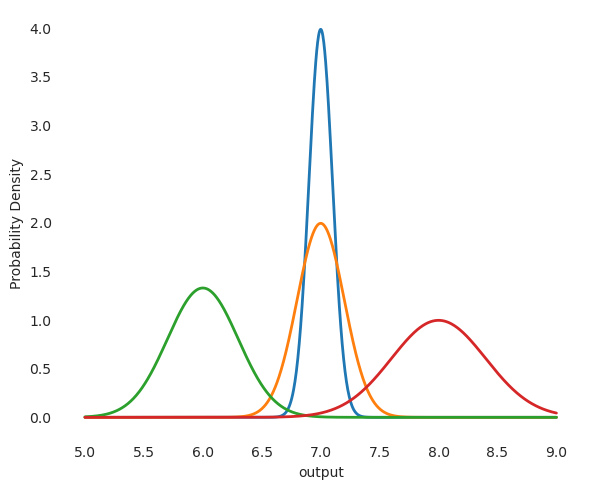

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the normal distributions
mu1, sigma1 = 7, 0.1  # mean and standard deviation
mu2, sigma2 = 7, 0.2
mu3, sigma3 = 6, 0.3
mu4, sigma4 = 8, 0.4
# Generate data points
x = np.linspace(5, 9, 1000)
y1 = (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu1)**2 / (2 * sigma1**2) )
y2 = (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu2)**2 / (2 * sigma2**2) )
y3 = (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu3)**2 / (2 * sigma3**2) )
y4 = (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu4)**2 / (2 * sigma4**2) )
# Create the plot
plt.figure(figsize=(6, 5))
plt.plot(x, y1, label=f'$\mu={mu1}, \sigma={sigma1}$', linewidth=2)
plt.plot(x, y2, label=f'$\mu={mu2}, \sigma={sigma2}$', linewidth=2)
plt.plot(x, y3, label=f'$\mu={mu3}, \sigma={sigma3}$', linewidth=2)
plt.plot(x, y4, label=f'$\mu={mu4}, \sigma={sigma4}$', linewidth=2)

# # Add annotations for sigma
# plt.annotate(f'$\sigma={sigma1}$', xy=(mu1 + sigma1, (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (sigma1)**2 / (2 * sigma1**2) )), xytext=(mu1 + sigma1 + 1, (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (sigma1)**2 / (2 * sigma1**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma2}$', xy=(mu2 + sigma2, (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (sigma2)**2 / (2 * sigma2**2) )), xytext=(mu2 + sigma2 + 1, (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (sigma2)**2 / (2 * sigma2**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma3}$', xy=(mu3 + sigma3, (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (sigma3)**2 / (2 * sigma3**2) )), xytext=(mu3 + sigma3 + 1, (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (sigma3)**2 / (2 * sigma3**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma4}$', xy=(mu4 + sigma4, (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (sigma4)**2 / (2 * sigma4**2) )), xytext=(mu4 + sigma4 + 1, (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (sigma4)**2 / (2 * sigma4**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))

# Add title and labels
# plt.title('Normal Distributions with Different $\mu$ and $\sigma$')
plt.xlabel('output')
plt.ylabel('Probability Density')
# plt.legend()

# Show the plot
plt.grid(False)
# No background
plt.gca().set_facecolor('white') 
# save the plot
plt.tight_layout()
plt.savefig('normal_distributions.png', dpi=1200)
plt.savefig('normal_distributions.pdf')
plt.savefig('normal_distributions.svg')
plt.show()
